## Rate Model of 1 Excitatory and 2 Inhibitory populations
3 Wilson-Cowan style populations with feedforward input from thalamus and recurrent connections.

Following the 2 population model in Natan et al 2015, 4 population model in Litwin-Kumar et al 2016, and 3 population model in Park and Geffen 2019

Rough outline:
0. Make general model with 3x3 weight matrix
1. Implement all of Park population and stimulation pattern

1. Reproduce one iso-frequency unit 
3. Reproduce three iso-frquency unit model outcome 
4. Introduce 
5. Extend to reproduce experimental findings in Natan  

# other ideas:
learning rule Hebbian - pca on the inputs  
- SSA not really a long term plasticiy phenomenon but rather STP
depression of different feed forward inputs  


In [331]:
# CHECK Differential effect on off non linearity
# start counting from 0 not 1
# test diff non linearities cur off not cut off

# change back to non linearity

In [332]:
from IPython.display import HTML, IFrame, Image

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os, fnmatch
import time
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy import stats
from scipy import optimize
from scipy.signal import decimate
from scipy import signal
from scipy import integrate
import seaborn as sns
import random


import gc
import time

#%matplotlib inline
%matplotlib notebook

from matplotlib import rcParams, cm
rcParams['grid.linewidth'] = 0
rcParams['pdf.fonttype'] = 42
# import custom functions


# import custom functions
from helper_functions import *
import helper_functions

# reload(helper_functions)
# from helper_functions import *
figure_directory = "/home/auguste/Documents/CNE_PhD/organisation/Cajal/Project/code/1E3I/figures/park/"
fontsize = 20

from scipy import integrate

import seaborn as sns
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size']=14
#plt.rcParams['font.family']='SansSerif'

In [333]:
### network architectures
def network(r, t, J, T):    
    drdt = (-r + transfer_func(mu(t) + np.dot(J,r)))/T
    return drdt

def linear_network(r, t, W, T):    
    # linearized network
    # r is a 4-D vector that represents the firing rate of the units
    drdt = (np.dot(W,r)-r + mu(t))/T
    return drdt

def network_TC_adapt(y, t, W, T, T_adapt, g0):
    # network with thalamocortical adaptation
    # y represents the firing rate of the units and the adaptation variables    
    r,g = y[:3], y[3:]
    
    thalamic = generic_constant_input(t, thalamic_drive, thalamic_onset)
    opto = generic_constant_input(t,opto_drive, opto_onset)
    
    # does not depress
#    mu = thalamic + opto
    # depressing synapse
    mu = thalamic*np.hstack((g,[0,0])) + opto
    
    drdt = (np.dot(W,r)-r + mu)/T

    # synaptic adaptation
    # T_g (recovery), T_r (depression)
    r_pre = thalamic[:2]
    T_g, T_r = T_adapt[0,:], T_adapt[1,:]
    dgdt = (g0-g)/T_g - (g*r_pre)/T_r

    dydt = np.hstack((drdt,dgdt))
    return dydt

### transfer functions
def transfer_func(curr_input):
    # transfer function from current to firing rate    
    return curr_input**2

### input functions
def generic_constant_input(t,v=0,t_onset=0.1):
    if t<=t_onset:
        return np.zeros_like(v)
    else:
        return v
    
def mu(t):
    # time-varying input to the network    
    thalamic = generic_constant_input(t,thalamic_drive, thalamic_onset)
    opto = generic_constant_input(t,opto_drive, opto_onset)
    total_drive = thalamic + opto
    return total_drive

### plotting
def plot_rates(t,r,savetitle="rates", figsize=(12,6)):
    #figsize=figsize
    labels = ['E','PV','SOM','VIP']

    xlabel = r"time [s]"
    ylabel =r"firing rate [Hz]"

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    axiswidth = 1.5
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(axiswidth)
    ax.xaxis.set_tick_params(width=axiswidth)
    ax.yaxis.set_tick_params(width=axiswidth)
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)
    #plt.plot(x,x_nl, lw = 3, c = "darkblue", label="k = 10")
   # plt.subplot(2,1,1)
    for i in reversed(range(len(r[0,:]))):
        plt.plot(t,r[:,i],color=color[i],label=labels[i])
        
    #plt.ylabel('Firing Rate (Hz)')
    #plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

    # for q in steps:
    #     plt.axhline(y=q, c="grey")
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.legend(fontsize = fontsize, frameon=False)
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    plt.tight_layout()

    save_fig(figure_directory, savetitle)
    
def plot_currents(t,r,W, savetitle="total_currents"):
    labels = ['E','PV','SOM','VIP']
    Ie, Ii = return_EI(r,W)
    plt.plot(t,Ie, 'midnightblue', label='E Total')
    plt.plot(t,Ii, 'darkred', label='I Total')
    plt.xlabel('time [s]')
    plt.ylabel('Current')
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.legend(fontsize = fontsize)
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    plt.tight_layout()

    save_fig(figure_directory, savetitle)

### analysis
def return_EI(r, W):
    curr = W[0,:]*r
    Ie, Ii=curr[:,0], -curr[:,1:].sum(1)
    return Ie-Ie[0],Ii-Ii[0]


In [334]:
# def transfer_func_park(r,gain = 3, r_max = 1, r_min = 0 ):
#     # transfer function from 9,rx,r to firing rate
#     if r < r_min:
#         r = r_min
#     elif r > r_max:
#         r = gain
#     else:
#         r = gain*r
#     return r

def transfer_func_park(r,gain = 3, r_max = 1, r_min = 0 ):
    # transfer function from 9,rx,r to firing rate
    if r < r_min:
        r = r_min
    elif r > 1/gain:
        r = 1
    else:
        r = gain*r
    return r


def stimulus(dur=0.1,pause=0.3, T = 10):
    ''' generate input stimulus 
    input:
    dur tone duration: 100 ms
    pause inter stimulus pause 300 ms
    T total run time 
    output:
    numpy array with spiketimes'''
    N_pulse = int(np.floor(T/(dur+pause)))-1
    print(N_pulse)
    stim = np.zeros((N_pulse,2))
    for i in range(N_pulse):
        stim[i,0] = (i+1)*(dur+pause)
    stim[:,1] = stim[:,0] + dur
    return stim
# forward euler 
# get thalamic input right
# model g ffw adaptation

def thalamic_input_current(stimtimes, t, tau = 0.01, q = 5.):
    I = np.zeros(len(t))
    dt = t[1]-t[0]
    counter = 0
    for i in range(len(t)-1):
        I[i+1] = I[i] + (-I[i]/tau)*dt
        
        if counter <= len(stimtimes)-1 and t[i] >= stimtimes[counter]:
            #print(counter)
            #print(t[i])
            I[i+1] += q
            counter += 1
    return I

def thalamic_adaptation(I, t, tau_d1 = 1.5,tau_d2 = 0.1, g0 = 1.):
    # return thalamic adaptation of one synapse g
    # I input current 
    # t total time
    # taud1 replenishment of NT at synapse 1.5s
    # depletion of vesicles 
    g = np.ones(len(t))
    dt = t[1]-t[0]
    for i in range(len(t)-1):
        dgdt = (g0-g[i])/tau_d1 - g[i]*I[i]/tau_d2
        g[i+1] = g[i] + dgdt*dt
    return g

def ssa_stimulus(t,p_dev=0.1,dur_stim = 0.1,dur_pause=0.3, conditions = 10):
    '''generate ssa stimulus:
    two tones one with 90% occurence other with 10%
    randomly select either 
    '''
    stimtimes = stimulus(dur=dur_stim,pause=dur_pause,T=max(t))
    #print(stimtimes[:,0])
    N = int(p_dev*len(stimtimes[:,0]))
    #print(N)            
    st1 = sorted(stimtimes[:,0], key=lambda k: random.random())
    #print(st1)
    st2 = st1[N:]
    st1 = st1[:N]
    return st1,st2

def SSA(DA, DB, SA, SB):
    return (DA+DB-SA-SB)/(DA+DB+SA+SB)

def get_max_FR(r_trials):
    return np.array([np.max(r_trials[i,:]) for i in range(r_trials.shape[0])])


def thalamic_input_current(stimtimes, t, tau = 0.01, q = 5.):
    I = np.zeros(len(t))
    dt = t[1]-t[0]
    counter = 0
    for i in range(len(t)-1):
        I[i+1] = I[i] + (-I[i]/tau)*dt
        
        if counter <= len(stimtimes)-1 and t[i] >= stimtimes[counter]:
            #print(counter)
            #print(t[i])
            I[i+1] += q
            counter += 1
    return I

def thalamic_adaptation(I, t, tau_d1 = 1.5,tau_d2 = 0.1, g0 = 1.):
    # return thalamic adaptation of one synapse g
    # I input current 
    # t total time
    # taud1 replenishment of NT at synapse 1.5s
    # depletion of vesicles 
    g = np.ones(len(t))
    dt = t[1]-t[0]
    for i in range(len(t)-1):
        dgdt = (g0-g[i])/tau_d1 - g[i]*I[i]/tau_d2
        g[i+1] = g[i] + dgdt*dt
    return g

def inhib_suppresion(opto_input,stimtimes,t, stimdur=0.2, suppresion = -1, time_pre = 0.1, som = True):
    dt = t[1]-t[0]
    samples_before_stim=int(time_pre/dt)
    #print(samples_before_stim)
    samples_opto=int(stimdur/dt)
    #print(samples_opto)

    neuron_type = 1
    if som:
        neuron_type = 2
    for i in range(len(stimtimes)):
        idxmin = np.argmin(t<stimtimes[i])
        #print(idxmin)
        onset = max([idxmin-samples_before_stim,0])
        #print(onset)

        endopto = min([idxmin-samples_before_stim+samples_opto,len(t)-1])
        #print(endopto)

        opto_input[neuron_type,onset:endopto] = suppresion
    return opto_input

def get_peak_vals(rate, neuron_type=0):
    # get peaks in trace
    # neuron type 0 E, 1 PV, 2 SOM
    peak_idx = find_peaks(rate[neuron_type,:], distance = 2)[0]
    peak_val = rate[neuron_type,peak_idx]
    return peak_val, peak_idx

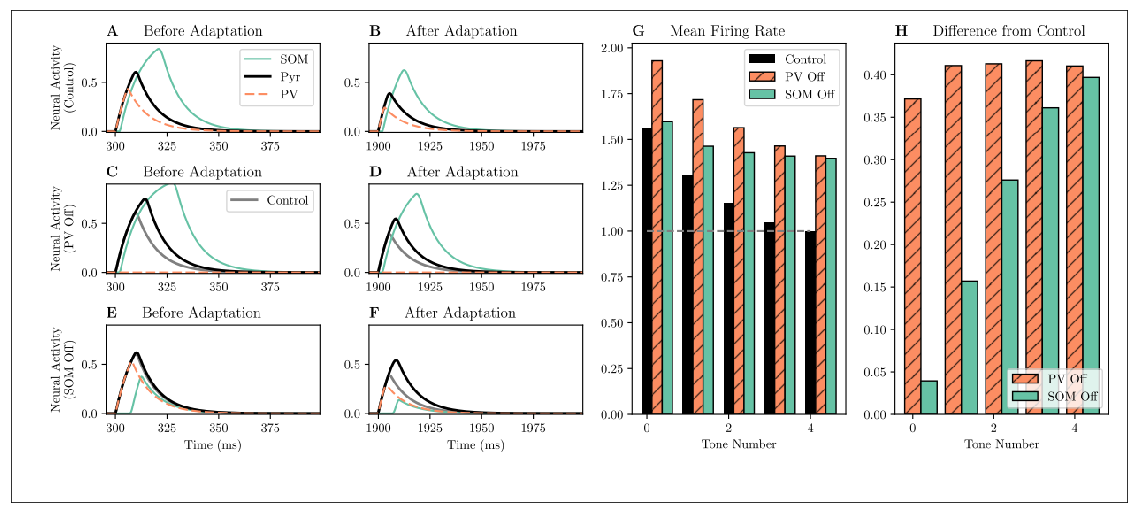

In [335]:
import matplotlib.image as mpimg
%matplotlib inline
img=mpimg.imread('/home/auguste/Documents/CNE_PhD/organisation/Cajal/Project/presentation/isomod.png')
fig = plt.figure(figsize = (20,15))
plt.xticks([])
plt.yticks([])

imgplot = plt.imshow(img)
plt.show()


# Parameter initialisation

τu
du(t) dtwpss
= −u(t) + f (weeu −wepp −wess + qI(t))  
, τp
dp(t) dt
= −p(t) + f (wpeu −wppp −wpss + IOpt,PV + qI(t))  
, τs
ds(t) dt
= −s(t) + f(wseu −wspp −wsss + IOpt,SOM),   
(1)

The input function I(t) consists of blocks of inputs with stimulus interval
δms. When an auditory input arrives, the default temporal profile is taken to have an instantaneous rise with amplitude q and exponential decay with time constant τq = 10ms [40]. The input I(t) is further modulated by a slow timecourse synaptic depression term g satisfying
dg(t)/dt = (g0 − g(t))/τd1 − g(t)I(t)/τd2 , (3) where the time constants are τd1 = 1500ms for replenishment and τd2 = 20ms

In [336]:
color = ["midnightblue","darkgreen","darkorange","purple"]

#r0 = np.array([4,3,3]).T
T, dt = 10, 0.0001
t = np.arange(0,T,dt)
#tau_neurons = np.array([0.02, 0.02, 0.02]).T
thalamic_drive = np.array([1,1,0]).T
thalamic_onset = 0.2

opto_drive = np.array([0,0,0]).T
opto_onset = 0.2

W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1.1,-2,-1,1,-2,-2,6,0,0]
#W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1,0,0,0,0,0,0,0,0]


W = np.array([[W_EE, W_ES, W_EP],
              [W_PE, W_PP, W_PS],
              [W_SE, W_SP, W_SS]])


taus = np.array([0.01, 0.01, 0.01]).T # all populations have a timeconstant of 10 ms
#uth = 1.
#pth = 1.
#sth = 0.7
uth = 0.7
pth = 1.
sth = 1.0
thr = np.array([uth,pth,sth]).T
#r = integrate.odeint(linear_network, r0, t, args=(W, taus))
# initialise the stimulus
stim = stimulus()
# I(t) given the input times
# manual
sst1 = [2.4, 4.8, 7.2]
sst2 = [0.4, 0.8, 1.2, 1.6, 2. , 2.8, 3.2, 3.6, 4. , 4.4, 5.2,
       5.6, 6. , 6.4, 6.8, 7.6, 8. , 8.4, 8.8, 9.2, 9.6]
I = thalamic_input_current(stim[:,0],t)
I = thalamic_input_current(sst2,t)

# adaptation time constant
g = thalamic_adaptation(I,t,g0=1) # initialised with g = 1 and g0 = 1
thalamic_input = I*g # final input current only to PV and E
q = 1.3

24


In [337]:
external_input = q*np.tile(thalamic_input,(3,1))
thalamic_drive = np.array([1,1,0]).T 
external_input[2] = 0 # no input to SOM

In [338]:
r = np.zeros((3,len(t)))
# r[0,0]=4
# r[1,0]=9
# r[2,0]=5

#dt = t[1]-t[0]
print(dt)
print(W)
for i in range(len(t)-1):
    total_input = (np.dot(W,r[:,i]) + external_input[:,i]-thr)
    for k in range(len(total_input)):
        total_input[k] = transfer_func_park(total_input[k])
    
    drdt = -r[:,i] + total_input
#     print(np.dot(W,r[:,i]))
#     print(q*mu[:,i])
#     print(thr)
    #print(drdt)

    r[:,i+1] = r[:,i] + drdt*dt/taus # integration step
    #print(r[:,i+1])
    #print(r[:,i])


0.0001
[[ 1.1 -2.  -1. ]
 [ 1.  -2.  -2. ]
 [ 6.   0.   0. ]]


<IPython.core.display.Javascript object>


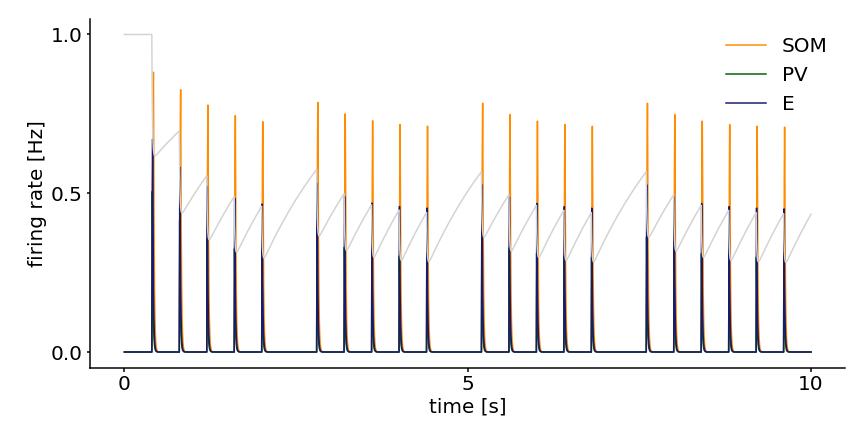

In [339]:
%matplotlib notebook
#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,r.T,savetitle='rates_positive_rlong')

plt.plot(t,g, color='lightgrey')
save_fig(figure_directory, "all_activities_g_rlong")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeuplong")

In [329]:
plt.plot(I*g)

# Opto suppression

In [340]:
color = ["midnightblue","darkgreen","darkorange","purple"]

#r0 = np.array([4,3,3]).T
T, dt = 10, 0.0001
t = np.arange(0,T,dt)
#tau_neurons = np.array([0.02, 0.02, 0.02]).T
thalamic_drive = np.array([1,1,0]).T
thalamic_onset = 0.2

opto_drive = np.array([0,0,0]).T
opto_onset = 0.2

W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1.1,-2,-1,1,-2,-2,6,0,0]
#W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1,0,0,0,0,0,0,0,0]


W = np.array([[W_EE, W_ES, W_EP],
              [W_PE, W_PP, W_PS],
              [W_SE, W_SP, W_SS]])


taus = np.array([0.01, 0.01, 0.01]).T # all populations have a timeconstant of 10 ms
q = 1.3 # 2nd q that multiplies the thalamic input distinct from q=5 for current 

#uth = 1.
#pth = 1.
#sth = 0.7
uth = 0.7
pth = 1.
sth = 1.0
thr = np.array([uth,pth,sth]).T
#r = integrate.odeint(linear_network, r0, t, args=(W, taus))
# initialise the stimulus
stim = stimulus()
# I(t) given the input times
I = thalamic_input_current(stim[:,0],t)
# adaptation time constant
g = thalamic_adaptation(I,t,g0=1) # initialised with g = 1 and g0 = 1
thalamic_input = I*g # final input current only to PV and E

external_input = q*np.tile(thalamic_input,(3,1))
thalamic_drive = np.array([1,1,0]).T 
external_input[2] = 0 # no input to SOM
opto_input = np.zeros((3,len(t)))
opto_input=inhib_suppresion(opto_input,stim[:,0],t, stimdur=0.2, suppresion = -4, time_pre = 0.1, som = True)
r = np.zeros((3,len(t)))
# r[0,0]=4
# r[1,0]=9
# r[2,0]=5

#dt = t[1]-t[0]
print(dt)
print(W)
for i in range(len(t)-1):
    total_input = (np.dot(W,r[:,i]) + external_input[:,i]-thr)
    for k in range(len(total_input)):
        total_input[k] = transfer_func_park(total_input[k])
    
    drdt = -r[:,i] + total_input
#     print(np.dot(W,r[:,i]))
#     print(q*mu[:,i])
#     print(thr)
    #print(drdt)

    r[:,i+1] = r[:,i] + drdt*dt/taus # integration step

24
0.0001
[[ 1.1 -2.  -1. ]
 [ 1.  -2.  -2. ]
 [ 6.   0.   0. ]]


# Iso frequency Opto suppression

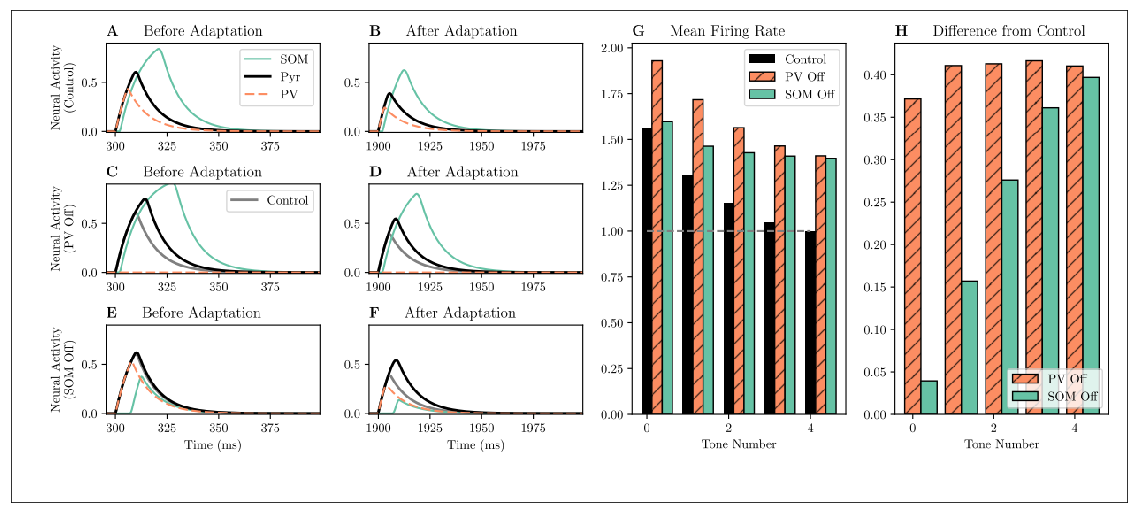

In [341]:
import matplotlib.image as mpimg
%matplotlib inline
img=mpimg.imread('/home/auguste/Documents/CNE_PhD/organisation/Cajal/Project/presentation/isomod.png')
fig = plt.figure(figsize = (20,15))
plt.xticks([])
plt.yticks([])

imgplot = plt.imshow(img)
plt.show()


In [342]:
color = ["darkblue","darkgreen","darkorange","purple"]

#r0 = np.array([4,3,3]).T
T, dt = 2.4, 0.0001
t = np.arange(0,T,dt)
#tau_neurons = np.array([0.02, 0.02, 0.02]).T
thalamic_drive = np.array([1,1,0]).T
thalamic_onset = 0.2

opto_drive = np.array([0,0,0]).T
opto_onset = 0.2

W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1.1,-2,-1,1,-2,-2,6,0,0]
#W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1,0,0,0,0,0,0,0,0]


W = np.array([[W_EE, W_ES, W_EP],
              [W_PE, W_PP, W_PS],
              [W_SE, W_SP, W_SS]])


taus = np.array([0.01, 0.01, 0.01]).T # all populations have a timeconstant of 10 ms
q = 1.3 # 2nd q that multiplies the thalamic input distinct from q=5 for current 

#uth = 1.
#pth = 1.
#sth = 0.7
uth = 0.7
pth = 1.
sth = 1.0
thr = np.array([uth,pth,sth]).T
#r = integrate.odeint(linear_network, r0, t, args=(W, taus))
# initialise the stimulus
stim = stimulus()
# I(t) given the input times
I = thalamic_input_current(stim[:,0],t)
# adaptation time constant
g = thalamic_adaptation(I,t,g0=1) # initialised with g = 1 and g0 = 1
thalamic_input = I*g # final input current only to PV and E

external_input = q*np.tile(thalamic_input,(3,1))
thalamic_drive = np.array([1,1,0]).T 
external_input[2] = 0 # no input to SOM

opto_input = np.zeros((3,len(t)))
r = np.zeros((3,len(t)))
u1 = np.zeros((len(t)))
p1 = np.zeros((len(t)))
s1 = np.zeros((len(t)))

som_on = False
pv_on = False
control = True

if som_on:
    print('SOM_suppression')
    tag = 'SOM_suppression'
    I_opto = -1
    opto_input=inhib_suppresion(opto_input,stim[:,0],t, stimdur=0.2, suppresion = I_opto, time_pre = 0.1, som = True)
elif pv_on:
    print('PV_suppression')
    I_opto = -2
    tag = 'PV_suppression'
    opto_input=inhib_suppresion(opto_input,stim[:,0],t, stimdur=0.2, suppresion = I_opto, time_pre = 0.1, som = False)
else:
    print('Control')
    I_opto = 0
    tag = 'Control'


for i in range(len(t)-1):
    total_input = (np.dot(W,r[:,i]) + external_input[:,i]-thr)
    
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] + external_input[0,i] + opto_input[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] + external_input[1,i] + opto_input[1,i]- pth)
    sin1 = transfer_func_park(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i] + external_input[2,i] + opto_input[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]

r1 = np.array([u1,p1,s1])

if som_on:
    r_som = np.copy(r1)
    g_som = np.copy(g)
elif pv_on:
    r_pv = np.copy(r1)
    g_pv = np.copy(g)
elif control:
    r_control = np.copy(r1)
    g_control = np.copy(g)
# g will always be the same

max_ctrl, _ = get_peak_vals(r_control)
max_pv, _ = get_peak_vals(r_pv)
max_som, _ = get_peak_vals(r_som)

24
Control


# Run parameter sweep here

In [372]:
color = ["darkblue","darkgreen","darkorange","purple"]

#r0 = np.array([4,3,3]).T
T, dt = 2.4, 0.0001
t = np.arange(0,T,dt)
#tau_neurons = np.array([0.02, 0.02, 0.02]).T
thalamic_drive = np.array([1,1,0]).T
thalamic_onset = 0.2

opto_drive = np.array([0,0,0]).T
opto_onset = 0.2

W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1.1,-2,-1,1,-2,-2,6,0,0] # 2 E to SOM
#W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1,0,0,0,0,0,0,0,0]


W = np.array([[W_EE, W_ES, W_EP],
              [W_PE, W_PP, W_PS],
              [W_SE, W_SP, W_SS]])


taus = np.array([0.01, 0.01, 0.01]).T # all populations have a timeconstant of 10 ms
q = 1.3 # 2nd q that multiplies the thalamic input distinct from q=5 for current 

#uth = 1.
#pth = 1.
#sth = 0.7
uth = 0.7
pth = 1.
sth = 1.0
thr = np.array([uth,pth,sth]).T
#r = integrate.odeint(linear_network, r0, t, args=(W, taus))
# initialise the stimulus
stim = stimulus()
# I(t) given the input times
I = thalamic_input_current(stim[:,0],t)
# adaptation time constant
g = thalamic_adaptation(I,t,g0=1) # initialised with g = 1 and g0 = 1
thalamic_input = I*g # final input current only to PV and E
q=1.3
external_input = q*np.tile(thalamic_input,(3,1))
thalamic_drive = np.array([1,1,0]).T 
external_input[2] = 0 # no input to SOM

opto_input = np.zeros((3,len(t)))
r = np.zeros((3,len(t)))


som_on = False
pv_on = False
control = True

def transfer_func_park(r,gain = 3, r_max = 1, r_min = 0 ):
    # transfer function from 9,rx,r to firing rate
    if r < r_min:
        r = r_min
    elif r > 1/gain: # deleted threshold
        r = 1
    else:
        r = gain*r
    return r

# SOM---------------------------------------------- SOM ---------------------------------

u1 = np.zeros((len(t)))
p1 = np.zeros((len(t)))
s1 = np.zeros((len(t)))
print('SOM_suppression')
tag = 'SOM_suppression'
opto_input = np.zeros((3,len(t)))

I_opto_som = -1
opto_input=inhib_suppresion(opto_input,stim[:,0],t, stimdur=0.2, suppresion = I_opto_som, time_pre = 0.1, som = True)

for i in range(len(t)-1):
    total_input = (np.dot(W,r[:,i]) + external_input[:,i]-thr)
    
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] + external_input[0,i] + opto_input[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] + external_input[1,i] + opto_input[1,i]- pth)
    sin1 = transfer_func_park(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i] + external_input[2,i] + opto_input[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]

r_som = np.array([u1,p1,s1])



# PV ---------------------------------------------- PV ---------------------------------
u1 = np.zeros((len(t)))
p1 = np.zeros((len(t)))
s1 = np.zeros((len(t)))



print('PV_suppression')
I_opto_pv = -4
tag = 'PV_suppression'
opto_input = np.zeros((3,len(t)))
opto_input=inhib_suppresion(opto_input,stim[:,0],t, stimdur=0.2, suppresion = I_opto_pv, time_pre = 0.1, som = False)
for i in range(len(t)-1):
    total_input = (np.dot(W,r[:,i]) + external_input[:,i]-thr)
    
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] + external_input[0,i] + opto_input[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] + external_input[1,i] + opto_input[1,i]- pth)
    sin1 = transfer_func_park(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i] + external_input[2,i] + opto_input[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]

r_pv = np.array([u1,p1,s1])

# Control ----------------------------------------- Control --------------------------------------
    
opto_input = np.zeros((3,len(t)))
u1 = np.zeros((len(t)))
p1 = np.zeros((len(t)))
s1 = np.zeros((len(t)))
print('Control')

for i in range(len(t)-1):    
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] + external_input[0,i] + opto_input[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] + external_input[1,i] + opto_input[1,i]- pth)
    sin1 = transfer_func_park(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i] + external_input[2,i] + opto_input[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]


r_control = np.array([u1,p1,s1])
g_control = np.copy(g)
# g will always be the same

max_ctrl, _ = get_peak_vals(r_control)
max_pv, _ = get_peak_vals(r_pv)
max_som, _ = get_peak_vals(r_som)

24
SOM_suppression
PV_suppression
Control


# Delete Nonlinearities

24
SOM_suppression
PV_suppression
Control


<IPython.core.display.Javascript object>


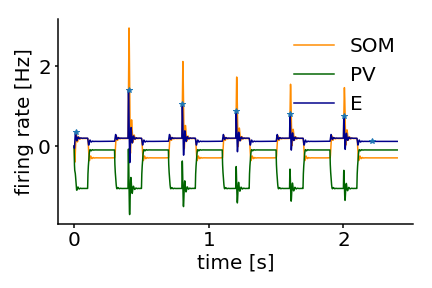

<IPython.core.display.Javascript object>


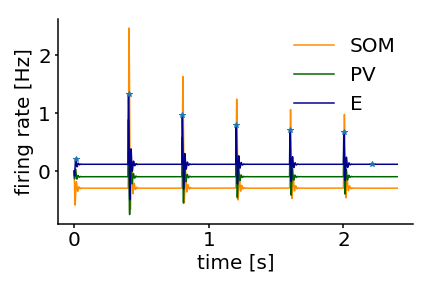

<IPython.core.display.Javascript object>


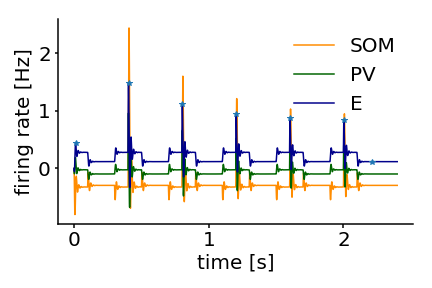

In [382]:
color = ["darkblue","darkgreen","darkorange","purple"]

#r0 = np.array([4,3,3]).T
T, dt = 2.4, 0.0001
t = np.arange(0,T,dt)
#tau_neurons = np.array([0.02, 0.02, 0.02]).T
thalamic_drive = np.array([1,1,0]).T
thalamic_onset = 0.2

opto_drive = np.array([0,0,0]).T
opto_onset = 0.2

W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1.1,-2,-1,1,-2,-2,6,0,0]
#W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1,0,0,0,0,0,0,0,0]


W = np.array([[W_EE, W_ES, W_EP],
              [W_PE, W_PP, W_PS],
              [W_SE, W_SP, W_SS]])


taus = np.array([0.01, 0.01, 0.01]).T # all populations have a timeconstant of 10 ms
q = 1.3 # 2nd q that multiplies the thalamic input distinct from q=5 for current 

#uth = 1.
#pth = 1.
#sth = 0.7
uth = 0.7
pth = 1.
sth = 1.0
thr = np.array([uth,pth,sth]).T
#r = integrate.odeint(linear_network, r0, t, args=(W, taus))
# initialise the stimulus
stim = stimulus()
# I(t) given the input times
I = thalamic_input_current(stim[:,0],t)
# adaptation time constant
g = thalamic_adaptation(I,t,g0=1) # initialised with g = 1 and g0 = 1
thalamic_input = I*g # final input current only to PV and E
q=1.3
external_input = q*np.tile(thalamic_input,(3,1))
thalamic_drive = np.array([1,1,0]).T 
external_input[2] = 0 # no input to SOM

opto_input = np.zeros((3,len(t)))
r = np.zeros((3,len(t)))


som_on = False
pv_on = False
control = True


def transfer_func_park(x):
    return x

def transfer_func_park_som(r,gain = 3, r_max = 1, r_min = 0 ):
    return r
#     # transfer function from 9,rx,r to firing rate
#     if r < r_min:
#         r = r_min
#     elif r > 1/gain:
#         r = 1
#     else:
#         r = gain*r
#     return r

# def transfer_func_park_som(r,gain = 3, r_max = 1, r_min = 0 ):
#     # transfer function from 9,rx,r to firing rate
#     if r < r_min:
#         r = r_min
#     elif r > 1/gain:
#         r = 1
#     else:
#         r = gain*r
#     return r

# def transfer_func_park(r,gain = 3, r_max = 1, r_min = 0 ):
#     # transfer function from 9,rx,r to firing rate
#     if r < r_min:
#         r = r_min
#     elif r > 1/gain:
#         r = 1
#     else:
#         r = gain*r
#     return r

# SOM---------------------------------------------- SOM ---------------------------------

u1 = np.zeros((len(t)))
p1 = np.zeros((len(t)))
s1 = np.zeros((len(t)))
print('SOM_suppression')
tag = 'SOM_suppression'
opto_input = np.zeros((3,len(t)))

I_opto_som = -1
opto_input=inhib_suppresion(opto_input,stim[:,0],t, stimdur=0.2, suppresion = I_opto_som, time_pre = 0.1, som = True)

for i in range(len(t)-1):
    total_input = (np.dot(W,r[:,i]) + external_input[:,i]-thr)
    
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] + external_input[0,i] + opto_input[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] + external_input[1,i] + opto_input[1,i]- pth)
    sin1 = transfer_func_park_som(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i] + external_input[2,i] + opto_input[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]

r_som = np.array([u1,p1,s1])



# PV ---------------------------------------------- PV ---------------------------------
u1 = np.zeros((len(t)))
p1 = np.zeros((len(t)))
s1 = np.zeros((len(t)))



print('PV_suppression')
I_opto_pv = -2
tag = 'PV_suppression'
opto_input = np.zeros((3,len(t)))
opto_input=inhib_suppresion(opto_input,stim[:,0],t, stimdur=0.2, suppresion = I_opto_pv, time_pre = 0.1, som = False)
for i in range(len(t)-1):
    total_input = (np.dot(W,r[:,i]) + external_input[:,i]-thr)
    
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] + external_input[0,i] + opto_input[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] + external_input[1,i] + opto_input[1,i]- pth)
    sin1 = transfer_func_park_som(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i] + external_input[2,i] + opto_input[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]

r_pv = np.array([u1,p1,s1])

# Control ----------------------------------------- Control --------------------------------------
    
opto_input = np.zeros((3,len(t)))
u1 = np.zeros((len(t)))
p1 = np.zeros((len(t)))
s1 = np.zeros((len(t)))
print('Control')

for i in range(len(t)-1):    
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] + external_input[0,i] + opto_input[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] + external_input[1,i] + opto_input[1,i]- pth)
    sin1 = transfer_func_park_som(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i] + external_input[2,i] + opto_input[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]


r_control = np.array([u1,p1,s1])
g_control = np.copy(g)
# g will always be the same

max_ctrl, _ = get_peak_vals(r_control)
max_pv, _ = get_peak_vals(r_pv)
max_som, _ = get_peak_vals(r_som)

# issue now no longer just one peak
peak_idx = find_peaks(r_pv[0,:], distance = 2000)[0]
peak_val = r_pv[0,peak_idx]
plot_rates(t,r_pv.T,savetitle='testpeak'+tag+param_tag, figsize=(6,4))
plt.plot(peak_idx*dt, peak_val,'*')
max_pv = peak_val[1:]


peak_idx = find_peaks(r_control[0,:], distance = 2000)[0]
peak_val = r_control[0,peak_idx]
plot_rates(t,r_control.T,savetitle='testpeak'+tag+param_tag, figsize=(6,4))
plt.plot(peak_idx*dt, peak_val,'*')
max_ctrl = peak_val[1:]


peak_idx = find_peaks(r_som[0,:], distance = 2000)[0]
peak_val = r_som[0,peak_idx]
plot_rates(t,r_som.T,savetitle='testpeak'+tag+param_tag, figsize=(6,4))
plt.plot(peak_idx*dt, peak_val,'*')
max_som = peak_val[1:]


<IPython.core.display.Javascript object>


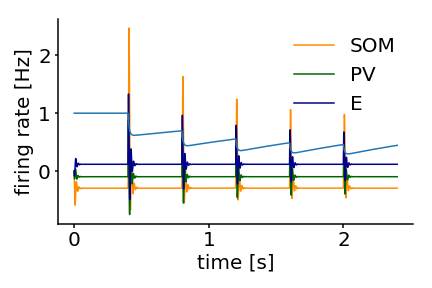

<IPython.core.display.Javascript object>


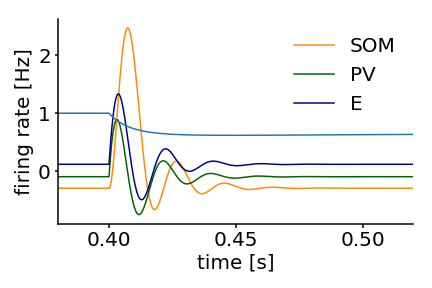

<IPython.core.display.Javascript object>


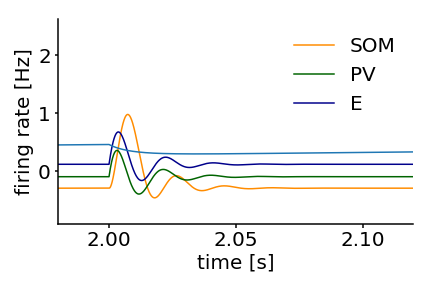

In [385]:
%matplotlib notebook
r1 = np.copy(r_control)
tag='control'
#r1 = np.copy(r_pv)
#tag='pvsup'
# r1 = np.copy(r_som)
# tag='somsup'
param_tag = 'q_' + str(q) + '_Ioptsom' + str(I_opto_som) +'_Ioptsom' + str(I_opto_pv) + '_NON_LINEARITY-atall'

#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,r1.T,savetitle='rates_positive_r1'+tag+param_tag, figsize=(6,4))
plt.plot(t,g)
#plt.plot(t,opto_input.T)

save_fig(figure_directory, "all_activities_g"+tag+param_tag)
# plt.plot(t,g*I, 'k')
plot_rates(t,r1.T,savetitle='rates_positive_r1'+tag+param_tag, figsize=(6,4))
plt.plot(t,g)
plt.xlim([0.38,0.52])

save_fig(figure_directory, "all_activities_g_closeup_first"+tag+param_tag)
plot_rates(t,r1.T,savetitle='rates_positive_r1'+tag+param_tag, figsize=(6,4))
plt.plot(t,g)
plt.xlim([1.98,2.12])# plt.plot(t,g*I, 'k')

save_fig(figure_directory, "all_activities_g_closeup_last"+tag+param_tag)


<IPython.core.display.Javascript object>


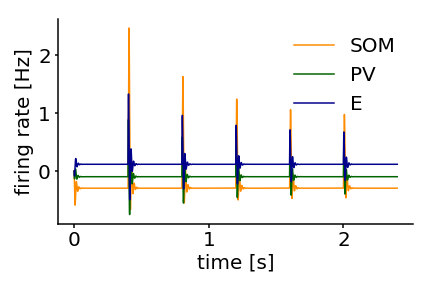

<IPython.core.display.Javascript object>


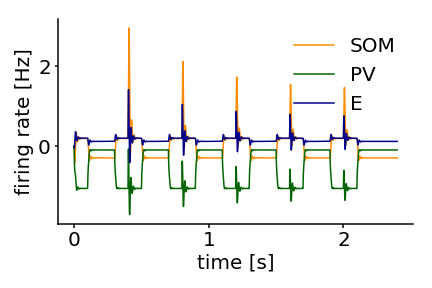

<IPython.core.display.Javascript object>


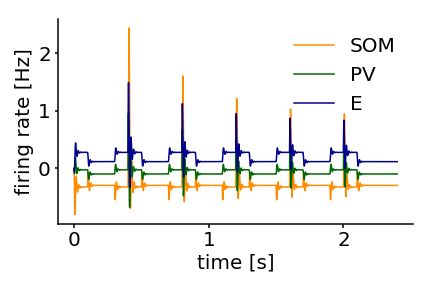

In [384]:
%matplotlib notebook
r1 = np.array([u1,p1,s1])
#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,r_control.T,savetitle='rates_positive_r1control_q5', figsize=(6,4))
plot_rates(t,r_pv.T,savetitle='rates_positive_r1pv_q5', figsize=(6,4))
plot_rates(t,r_som.T,savetitle='rates_positive_r1som_q5', figsize=(6,4))

# plt.plot(t,g)
# #plt.plot(t,opto_input.T)

# save_fig(figure_directory, "all_activities_g"+tag)
# plt.xlim([0.38,0.52])
# # plt.plot(t,g*I, 'k')
# save_fig(figure_directory, "all_activities_g_closeup_first"+tag)
# plt.xlim([1.98,2.12])# plt.plot(t,g*I, 'k')
# save_fig(figure_directory, "all_activities_g_closeup_last"+tag)


<IPython.core.display.Javascript object>


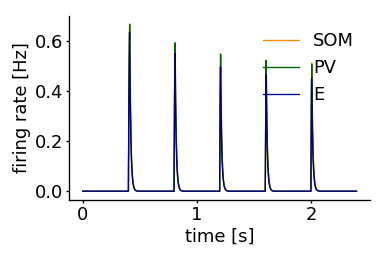

In [361]:
%matplotlib notebook
r_Eall = np.array([r_control[0,:],r_pv[0,:],r_som[0,:]])
#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,r_Eall.T,savetitle='rates_positive_r1_all_E', figsize=(6,4))


<IPython.core.display.Javascript object>


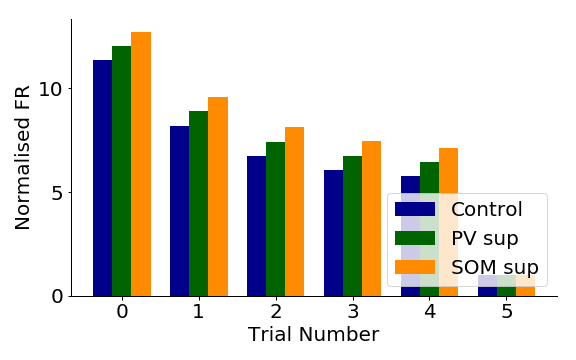

<IPython.core.display.Javascript object>


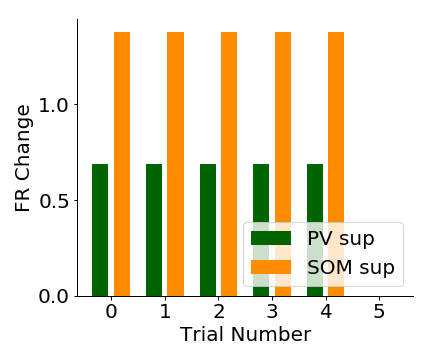

In [386]:
labels = ['E','PV','SOM','VIP']
figsize=(8,5)
#plt.bar(range(len(max_ctrl)), max_ctrl,color = 'midnightblue', edgecolor='blue', align='center', alpha=0.3)
bar_offset = 0.2
std_trial = 5
dev_trial = 0
N_trials = len(max_ctrl)

width = 0.25 
alpha = 0.65
axiswidth=1
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
x1 = np.linspace(0,N_trials-1,N_trials)
x2 = x1-width
x3 = x1+width
norm_ctrl = max_ctrl[-1]
plt.bar(x2,max_ctrl/norm_ctrl, width=width, label='Control', color=color[0])
plt.bar(x1,max_pv/norm_ctrl, width=width, label='PV sup', color=color[1])
plt.bar(x3,max_som/norm_ctrl, width=width, label='SOM sup', color=color[2])

plt.xlabel('Trial Number',fontsize = fontsize)
plt.ylabel('Normalised FR',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize, loc='lower right')
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=N_trials+1)
plt.tight_layout()

save_fig(figure_directory, 'barplot'+param_tag)

# ------------------------------------- difference plot -----------------------------------

figsize=(6,5)
#plt.bar(range(len(max_ctrl)), max_ctrl,color = 'midnightblue', edgecolor='blue', align='center', alpha=0.3)
bar_offset = 0.2
std_trial = 5
dev_trial = 0
N_trials = len(max_ctrl)

width = 0.3
alpha = 0.65
axiswidth=1
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
x1 = np.linspace(0,N_trials-1,N_trials)
x2 = x1-0.2
x3 = x1+0.2
#plt.bar(x1,max_ctrl, width=width, label='Control', color=color[0])
plt.bar(x2,max_pv/norm_ctrl-max_ctrl/norm_ctrl, width=width, label='PV sup', color=color[1])
plt.bar(x3,max_som/norm_ctrl-max_ctrl/norm_ctrl, width=width, label='SOM sup', color=color[2])

plt.xlabel('Trial Number',fontsize = fontsize)
plt.ylabel('FR Change',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize, loc='lower right')
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=N_trials+1)
plt.tight_layout()

save_fig(figure_directory, 'barplot_diff_from_control'+param_tag)


In [200]:
# captured difference iin PC OFF and SOM OFF
# differential effect only when different som and pv opto input

# difference in response delay discuss

In [35]:
range_dev=[int(0.38/dt),int(0.52/dt)]
range_std=[int(1.98/dt),int(2.12/dt)]
# deviant three conditions
std_cond_Ctrl = np.matrix(r_control[:,range_std[0]:range_std[1]]).max(1) # maximum E, PV, SOM activity in control condition on 5th repetition
std_cond_PV_sup =np.matrix(r_pv[:,range_std[0]:range_std[1]]).max(1)# maximum E, PV, SOM activity in PV off condition on 5th repetition
std_cond_SOM_sup =np.matrix(r_som[:,range_std[0]:range_std[1]]).max(1)# maximum E, PV, SOM activity in SOM off condition on 5th repetition
# deviant three conditions
dev_cond_Ctrl =np.matrix(r_control[:,range_dev[0]:range_dev[1]]).max(1)# maximum E, PV, SOM activity in control condition on first presentation
dev_cond_PV_sup =np.matrix(r_pv[:,range_dev[0]:range_dev[1]]).max(1)# maximum E, PV, SOM activity in PV off  condition on first presentation
dev_cond_SOM_sup =np.matrix(r_som[:,range_dev[0]:range_dev[1]]).max(1)# maximum E, PV, SOM activity in SOM off condition on first presentation
# to do.max(1)

# normalise everything to control standard

# determine ssa value
# explore weight matrix changes and how they effect ssa

# run richards param sweep DONE
# read park 

alpha = 0.65

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
plt.bar([1,2,3,5,6,7,],meanarr,color = c3, edgecolor=c3, yerr = stdarr, align='center', alpha=alpha)


In [46]:
std_cond_Ctrl=find_peaks(r_control[0,:], distance = 2)[0]
std_cond_Ctrl=r_control[0,std_cond_Ctrl]

<IPython.core.display.Javascript object>


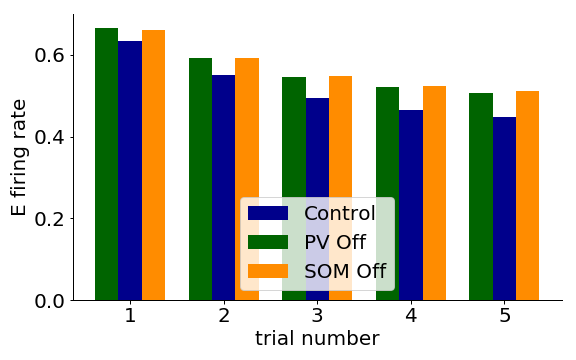

<IPython.core.display.Javascript object>


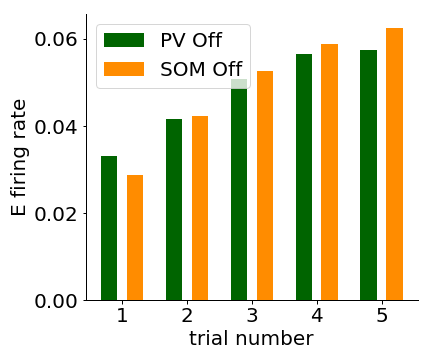

In [156]:
labels = ['E','PV','SOM','VIP']
figsize=(8,5)
#plt.bar(range(len(max_ctrl)), max_ctrl,color = 'midnightblue', edgecolor='blue', align='center', alpha=0.3)
bar_offset = 0.2
std_trial = 5
dev_trial = 0
N_trials = len(max_ctrl)

width = 0.25 
alpha = 0.65
axiswidth=1
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
x1 = np.linspace(1,N_trials,N_trials)
x2 = x1-width
x3 = x1+width
plt.bar(x1,max_ctrl, width=width, label='Control', color=color[0])
plt.bar(x2,max_pv, width=width, label='PV Off', color=color[1])
plt.bar(x3,max_som, width=width, label='SOM Off', color=color[2])

plt.xlabel('trial number',fontsize = fontsize)
plt.ylabel('E firing rate',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=N_trials+1)
plt.tight_layout()

save_fig(figure_directory, 'barplot')

figsize=(6,5)
#plt.bar(range(len(max_ctrl)), max_ctrl,color = 'midnightblue', edgecolor='blue', align='center', alpha=0.3)
bar_offset = 0.2
std_trial = 5
dev_trial = 0
N_trials = len(max_ctrl)

width = 0.25
alpha = 0.65
axiswidth=1
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
x1 = np.linspace(1,N_trials,N_trials)
x2 = x1-0.2
x3 = x1+0.2
#plt.bar(x1,max_ctrl, width=width, label='Control', color=color[0])
plt.bar(x2,max_pv-max_ctrl, width=width, label='PV Off', color=color[1])
plt.bar(x3,max_som-max_ctrl, width=width, label='SOM Off', color=color[2])

plt.xlabel('trial number',fontsize = fontsize)
plt.ylabel('E firing rate',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=N_trials+1)
plt.tight_layout()

save_fig(figure_directory, 'barplot_diff_from_control')

# list1 = [1, 2, 3,4,5,6,7]
# str1 = [str(e) for e in list1]

#plt.xlabel(x2, str1)

# plt.bar(x,max_pv, width=width)
# plt.bar(x+width/3.,max_som, width=width)


# for r_i, res in enumerate([max_ctrl, max_pv, max_som]):
#     plt.subplot(1,2,1)
#     plt.bar(0+bar_offset*(r_i-1), res[dev_trial-1,0], linewidth=2, width=0.15, edgecolor='k', color='w', alpha=0.8, label=labels[r_i])
#     plt.bar(1+bar_offset*(r_i-1), res[dev_trial,0], linewidth=2, width=0.15, edgecolor='k', color='r', alpha=0.6)
    

<IPython.core.display.Javascript object>


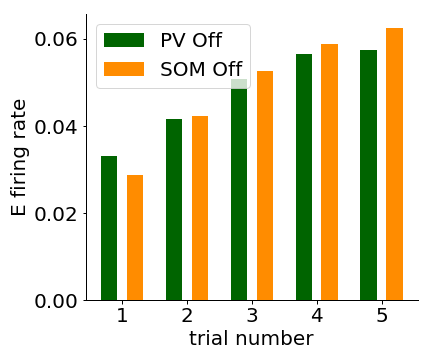

In [148]:
figsize=(6,5)
#plt.bar(range(len(max_ctrl)), max_ctrl,color = 'midnightblue', edgecolor='blue', align='center', alpha=0.3)
bar_offset = 0.2
std_trial = 5
dev_trial = 0
N_trials = len(max_ctrl)

width = 0.25
alpha = 0.65
axiswidth=1
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
x1 = np.linspace(1,N_trials,N_trials)
x2 = x1-0.2
x3 = x1+0.2
#plt.bar(x1,max_ctrl, width=width, label='Control', color=color[0])
plt.bar(x2,max_pv-max_ctrl, width=width, label='PV Off', color=color[1])
plt.bar(x3,max_som-max_ctrl, width=width, label='SOM Off', color=color[2])

plt.xlabel('trial number',fontsize = fontsize)
plt.ylabel('E firing rate',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=N_trials+1)
plt.tight_layout()

save_fig(figure_directory, 'barplot_diff_from_control')


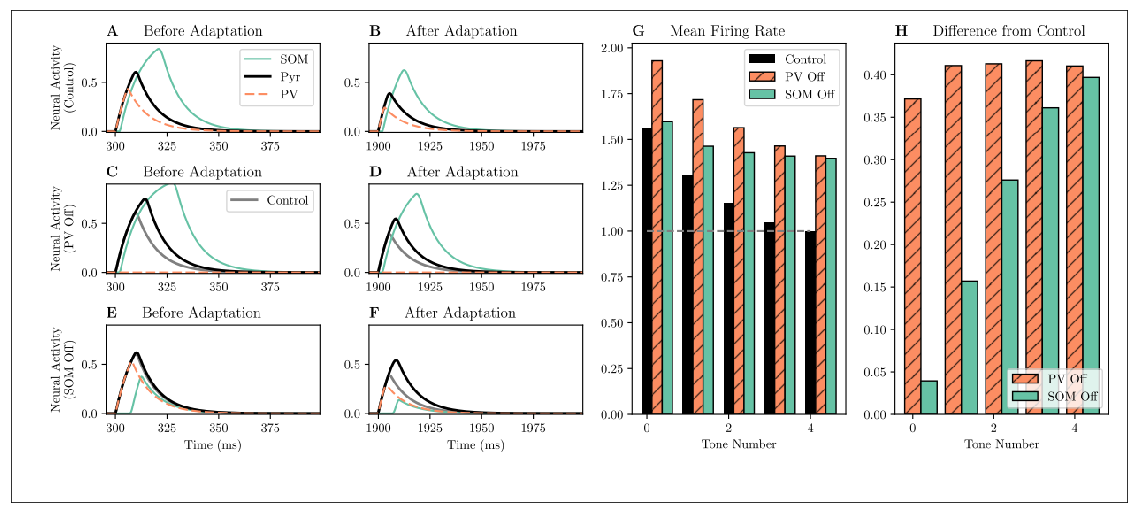

In [129]:
import matplotlib.image as mpimg
%matplotlib inline
img=mpimg.imread('/home/auguste/Documents/CNE_PhD/organisation/Cajal/Project/presentation/isomod.png')
fig = plt.figure(figsize = (20,15))
plt.xticks([])
plt.yticks([])

imgplot = plt.imshow(img)
plt.show()


In [34]:
def barplot_control(Nreps, array, array_blockavg, Nblocks = 10, ifxlims = True, figure_directory = "./",
 figsize=(14, 10), xlims = [0,45], alpha = 0.2, legend = "E", ifxticks = True, xtickstepsize = 3,
  iflegend = False, c1 = "grey",c3 = "darkgreen", c2 = "darkorange",lw = 3,fontsize = 24,
   xlabel = "number of repetitions", ylabel ="rate [Hz]",
    ifioff = True, ifsavefig = True, savename = "NrepsArrayerrorband", axiswidth = 1):
        """ plot Narrays vs. array (Nreps,Nblocks) array_blockavg (Nreps)"""
        if ifioff:
            plt.ioff()
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(axiswidth)
        for axis in ['top','right']:
            ax.spines[axis].set_linewidth(0)
        ax.xaxis.set_tick_params(width=axiswidth)
        ax.yaxis.set_tick_params(width=axiswidth)
        meanarr = np.mean(array, axis = 1)
        stdarr = np.std(array, axis = 1)
        plt.bar(Nreps,meanarr,color = c3, edgecolor=c3, yerr = stdarr, align='center', alpha=alpha)
        #
        # plt.plot(Nreps,array_blockavg, ":o", color = c2,  label = "block average")
        # #plt.plot(Nreps,meanarr, ":o", color = c3,  label = "mean individual blocks")
        # #plt.fill_between(Nreps, meanarr-stdarr, meanarr+stdarr, alpha=alpha edgecolor=c3, facecolor=c3)
        # plt.errorbar(Nreps, meanarr, yerr=stdarr, fmt='o', color = c3,
        #      ecolor=c3, elinewidth=2, capsize=3, label = "mean individual blocks")
        plt.xlabel(xlabel, fontsize = fontsize)
        plt.ylabel(ylabel, fontsize = fontsize)
        if ifxticks:
            plt.xticks(Nreps[0::xtickstepsize],fontsize = fontsize)
        else:
            plt.xticks(fontsize = fontsize)
        plt.yticks(fontsize = fontsize)
        plt.legend(fontsize = fontsize, frameon = True)
        plt.tight_layout()
        if ifxlims:
            xlims = [min(Nreps)-1,max(Nreps)+1]
            plt.xlim(xlims)
        if ifsavefig:
            save_fig(figure_directory, savename)



matrix([[0.63240748],
        [0.50595369],
        [0.85261589]])

In [28]:
def max_arr(matrix):
    dim1 = len(matrix[:,0])
    max_vals = np.zeros(dim1)
    for i in range():
        max_vals[i] = max(matrix[i,:])
    return max_vals

In [29]:
max_arr(std_cond_Ctrl)

TypeError: range expected 1 arguments, got 0

In [ ]:


plt.figure(figsize=(12,5))
textures = [None, '*', 'O']
labels=['Base', 'PV off', 'SOM off']
bar_offset = 0.2
for r_i, res in enumerate([res_baseline, res_optoPV, res_optoSOM]):
    plt.subplot(1,2,1)
    plt.bar(0+bar_offset*(r_i-1), res[3][dev_trial-1,0], linewidth=2, width=0.15, edgecolor='k', color='w', alpha=0.8, hatch=textures[r_i], label=labels[r_i])
    plt.bar(1+bar_offset*(r_i-1), res[3][dev_trial,0], linewidth=2, width=0.15, edgecolor='k', color='r', alpha=0.6, hatch=textures[r_i])
    
    plt.subplot(1,2,2)
    plt.bar(np.arange(len(stim_times))+bar_offset*(r_i-1)-dev_trial, res[3][:,0], width=0.2, hatch=textures[r_i], color=CKEYS[c_ord[r_i]], label=labels[r_i])

plt.legend(); plt.xlabel('Trials from Deviant Tone')

plt.subplot(1,2,1)
sns.despine(); plt.tight_layout()
plt.ylabel('E Rate (Hz)')
plt.xticks([0, 1], ['Standard', 'Deviant'])
plt.legend(); plt.tight_layout()

<IPython.core.display.Javascript object>


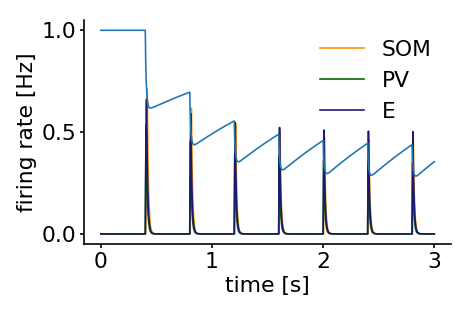

In [137]:
%matplotlib notebook
r1 = np.array([u1,p1,s1])
#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,r1.T,savetitle='rates_positive_r1_somsup', figsize=(6,4))

plt.plot(t,g)
#plt.plot(t,opto_input.T)

save_fig(figure_directory, "all_activities_g_r1_pv_sup")
#plt.xlim([1.98,2.12])
# plt.plot(t,g*I, 'k')
#save_fig(figure_directory, "all_activities_g_closeup_r1_pvsup_last")

<IPython.core.display.Javascript object>


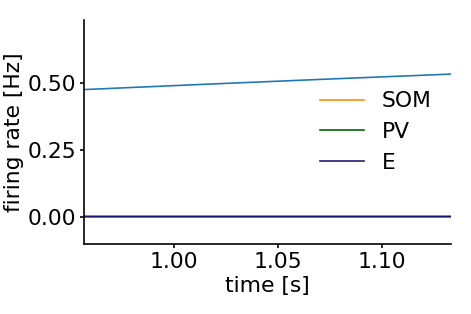

In [126]:
%matplotlib notebook
#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,rsom.T,savetitle='rates_positive_r1_somsup', figsize=(6,4))

plt.plot(t,g)
#plt.plot(t,opto_input.T)

save_fig(figure_directory, "all_activities_g_r1_pv_sup")
#plt.xlim([1.98,2.12])
# plt.plot(t,g*I, 'k')
#save_fig(figure_directory, "all_activities_g_closeup_r1_pvsup_last")

<IPython.core.display.Javascript object>


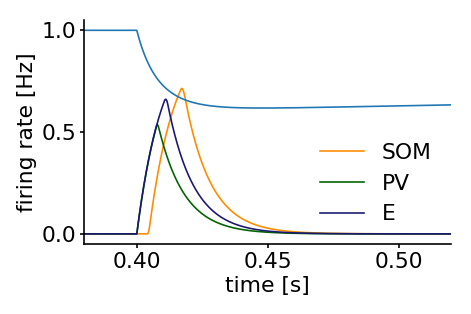

In [119]:
%matplotlib notebook
r1 = np.array([u1,p1,s1])
#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,r1.T,savetitle='rates_positive_r1', figsize=(6,4))

plt.plot(t,g)
#plt.plot(t,opto_input.T)

save_fig(figure_directory, "all_activities_g_r1")
plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r1_som_sup")
plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r1_som_sup_first")

<IPython.core.display.Javascript object>


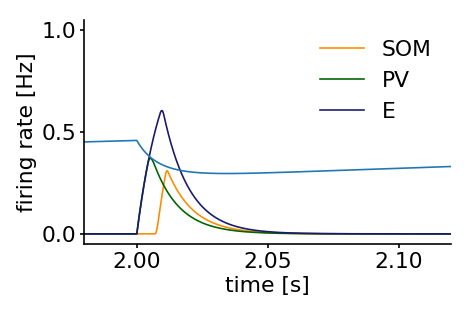

In [116]:
%matplotlib notebook
r1 = np.array([u1,p1,s1])
#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,r1.T,savetitle='rates_positive_r1_somsup', figsize=(6,4))

plt.plot(t,g)
#plt.plot(t,opto_input.T)

save_fig(figure_directory, "all_activities_g_r1_somsup")
plt.xlim([1.98,2.12])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r1_somsuplast")

In [120]:
rsom = np.copy(r1)

<IPython.core.display.Javascript object>


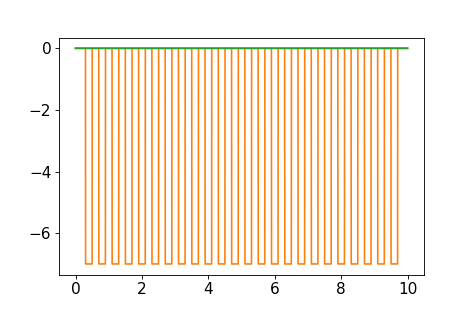

In [93]:
% matplotlib notebook
plt.plot(t,opto_input.T)

# 3 iso frequency model 

In [11]:
# ugly implementation of individual odes
u1 = np.zeros((len(t)))
p1 = np.zeros((len(t)))
s1 = np.zeros((len(t)))

u2 = np.zeros((len(t)))
p2 = np.zeros((len(t)))
s2 = np.zeros((len(t)))

u3 = np.zeros((len(t)))
p3 = np.zeros((len(t)))
s3 = np.zeros((len(t)))

external_input = q*np.tile(thalamic_input,(3,1))
external_input[2] = 0 # no input to SOM
opto_input = np.zeros((3,len(t)))

stim1 = stimulus()
# I(t) given the input times
I1 = thalamic_input_current(stim1[:,0],t)
# adaptation time constant
g1 = thalamic_adaptation(I,t,g0=1) # initialised with g = 1 and g0 = 1
thalamic_input1 = I1*g1 # final input current only to PV and E
external_input1 = q*np.tile(thalamic_input1,(3,1))
external_input1[2] = 0 # no input to SOM

# external_input1 = np.copy(external_input)
# external_input2 = np.copy(external_input)
# external_input3 = np.copy(external_input)

opto_input1 = np.copy(opto_input)
opto_input2 = np.copy(opto_input)
opto_input3 = np.copy(opto_input)

24


In [12]:
def thalamic_adaptation(I, t, tau_d1 = 1.5,tau_d2 = 0.1, g0 = 1.):
    # return thalamic adaptation of one synapse g
    # I input current 
    # t total time
    # taud1 replenishment of NT at synapse 1.5s
    # depletion of vesicles 
    g = np.ones(len(t))
    dt = t[1]-t[0]
    for i in range(len(t)-1):
        dgdt = (g0-g[i])/tau_d1 - g[i]*I[i]/tau_d2
        g[i+1] = g[i] + dgdt*dt
    return g



def three_unit_input_current(st1,st2,st3,t,alpha  = 0.65):
    # input spiketimes for three frequencies
    I1 = I2 = I3 = 0
    return I1,I2,I3

<IPython.core.display.Javascript object>


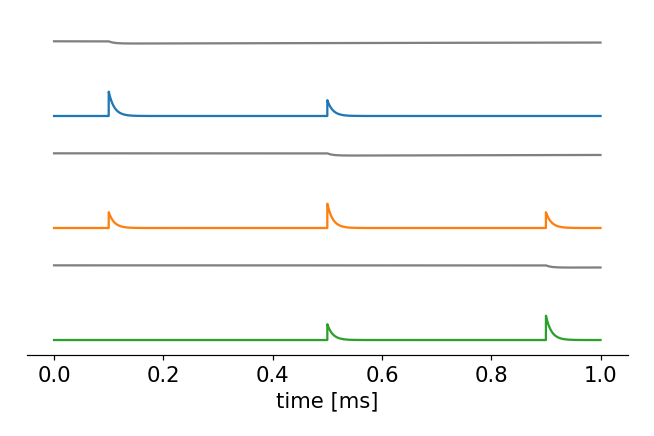

In [13]:
%matplotlib notebook
alpha = 0.65
st1 = [0.1, 1.3]
st2 = [0.5, 1.7]
st3 = [0.9, 2.1]

I1 = thalamic_input_current(st1,t,q=1.3)
I2 = thalamic_input_current(st2,t,q=1.3)
I3 = thalamic_input_current(st3,t,q=1.3)

g1 = thalamic_adaptation(I1,t,g0=1) # initialised with g = 1 and g0 = 1
g2 = thalamic_adaptation(I2,t,g0=1) # initialised with g = 1 and g0 = 1
g3 = thalamic_adaptation(I3,t,g0=1) # initialised with g = 1 and g0 = 1

#g1
# plt.plot(t,I1)
# plt.plot(t,I2)
# plt.plot(t,I3)
# plt.plot(t,g1)
# plt.plot(t,g2)
# plt.plot(t,g3)

in1 = I1 + alpha*I2
in2 = I2 + alpha*(I3+I1)
in3 = I3 + alpha*I2

external_input1 = q*np.tile(g1*in1,(3,1))
external_input2 = q*np.tile(g2*in2,(3,1))
external_input3 = q*np.tile(g3*in3,(3,1))

external_input1[2] = 0
external_input2[2] = 0
external_input3[2] = 0

figsize=(6,4)
xlabel = r"time [s]"
ylabel =r"thalamic input"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['top','right','left']:
        ax.spines[axis].set_linewidth(0)
plt.plot(t,in1+12, label='col 1')
plt.plot(t,in2+6, label='col 2')
plt.plot(t,in3, label='col 3')
plt.plot(t,g1+15, color='grey', label='g 1')
plt.plot(t,g2+9, color='grey', label='g 2')
plt.plot(t,g3+3, color='grey',label='g 3')
plt.yticks([])
#plt.legend()
plt.xlabel('time [ms]')
plt.tight_layout()

<IPython.core.display.Javascript object>


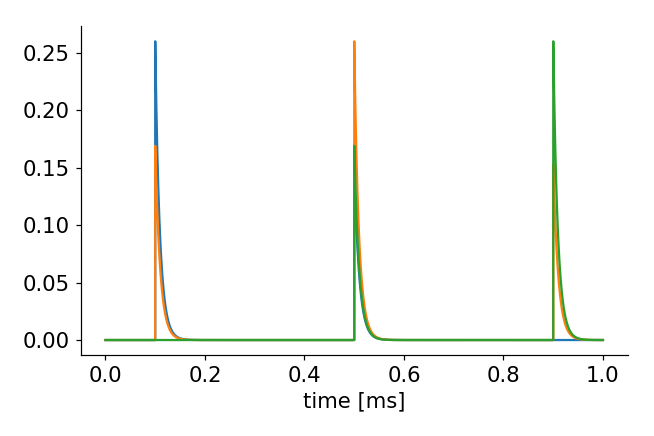

In [14]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)
plt.plot(t,external_input1[0,:]/(1.3*5), label='col 1')
plt.plot(t,external_input2[0,:]/(1.3*5), label='col 2')
plt.plot(t,external_input3[0,:]/(1.3*5), label='col 3')
# plt.plot(t,g1+15, color='grey', label='g 1')
# plt.plot(t,g2+9, color='grey', label='g 2')
# plt.plot(t,g3+3, color='grey',label='g 3')
#plt.yticks([])
#plt.legend()
plt.xlabel('time [ms]')
plt.tight_layout()

<IPython.core.display.Javascript object>


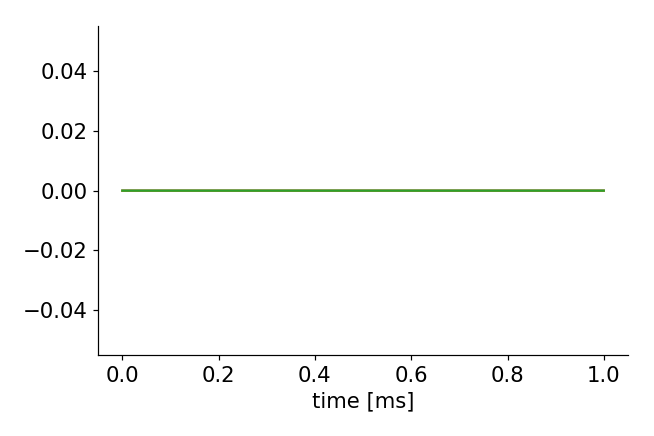

In [15]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)
plt.plot(t,external_input1[2,:]/(1.3*5), label='col 1')
plt.plot(t,external_input2[2,:]/(1.3*5), label='col 2')
plt.plot(t,external_input3[2,:]/(1.3*5), label='col 3')
# plt.plot(t,g1+15, color='grey', label='g 1')
# plt.plot(t,g2+9, color='grey', label='g 2')
# plt.plot(t,g3+3, color='grey',label='g 3')
#plt.yticks([])
#plt.legend()
plt.xlabel('time [ms]')
plt.tight_layout()

# Without lateral connections

In [16]:
for i in range(len(t)-1):
    # first column
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] 
                              + external_input1[0,i] + opto_input1[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] 
                              + external_input1[1,i] + opto_input1[1,i]- pth)
    sin1 = transfer_func_park(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i] 
                              + external_input1[2,i] + opto_input1[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]
    
    
    # second column
    uin2 = transfer_func_park(W_EE*u2[i] + W_EP*p2[i] + W_ES*s2[i] + external_input2[0,i] + opto_input2[0,i] - uth)
    pin2 = transfer_func_park(W_PE*u2[i] + W_PP*p2[i] + W_PS*s2[i] + external_input2[1,i] + opto_input2[1,i]- pth)
    sin2 = transfer_func_park(W_SE*u2[i] + W_SP*p2[i] + W_SS*s2[i] + external_input2[2,i] + opto_input2[2,i]- sth)
    
    
    du2dt = -u2[i] + uin2
    dp2dt = -p2[i] + pin2
    ds2dt = -s2[i] + sin2

    u2[i+1] = u2[i] + du2dt*dt/taus[0] # integration step
    p2[i+1] = p2[i] + dp2dt*dt/taus[1]
    s2[i+1] = s2[i] + ds2dt*dt/taus[2]
    
    
    # third colum
    uin3 = transfer_func_park(W_EE*u3[i] + W_EP*p3[i] + W_ES*s3[i] + external_input3[0,i] + opto_input3[0,i] - uth)
    pin3 = transfer_func_park(W_PE*u3[i] + W_PP*p3[i] + W_PS*s3[i] + external_input3[1,i] + opto_input3[1,i]- pth)
    sin3 = transfer_func_park(W_SE*u3[i] + W_SP*p3[i] + W_SS*s3[i] + external_input3[2,i] + opto_input3[2,i]- sth)
    
    
    du3dt = -u3[i] + uin3
    dp3dt = -p3[i] + pin3
    ds3dt = -s3[i] + sin3

    u3[i+1] = u3[i] + du3dt*dt/taus[0] # integration step
    p3[i+1] = p3[i] + dp3dt*dt/taus[1]
    s3[i+1] = s3[i] + ds3dt*dt/taus[2]
    
    

<IPython.core.display.Javascript object>


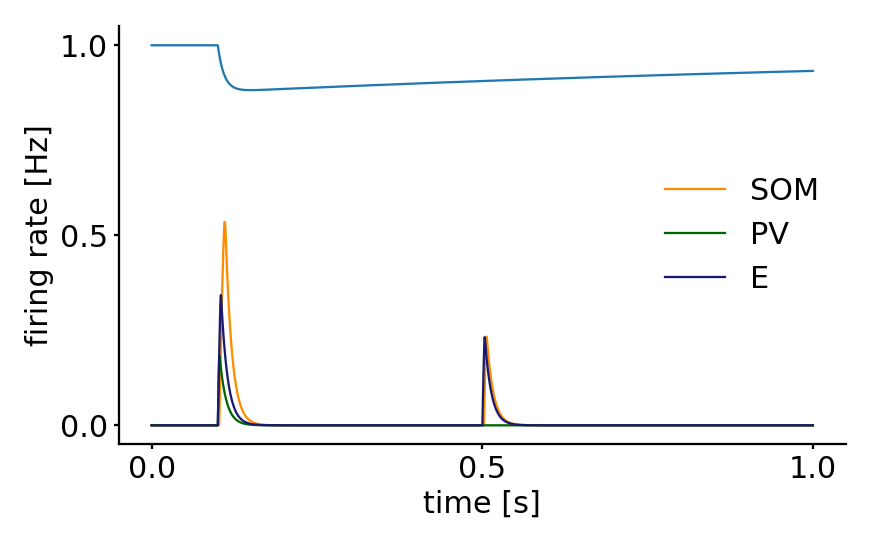

<IPython.core.display.Javascript object>


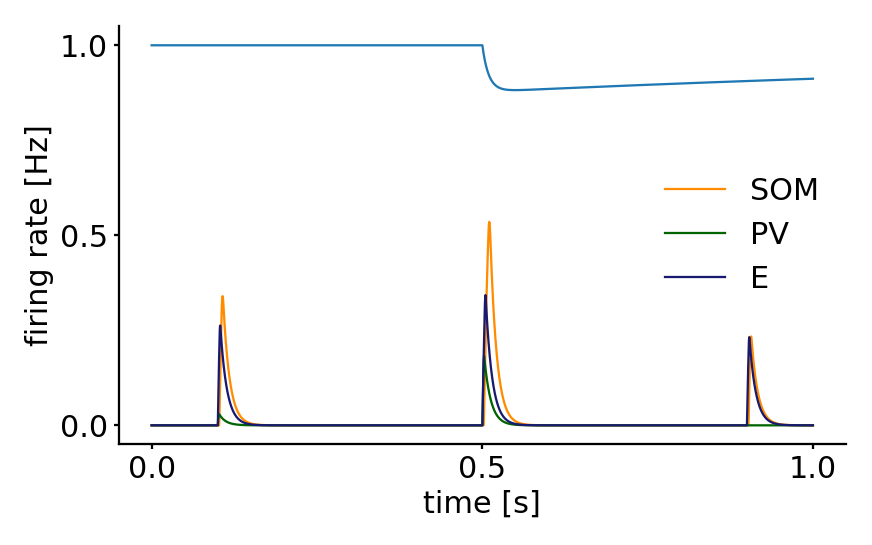

<IPython.core.display.Javascript object>


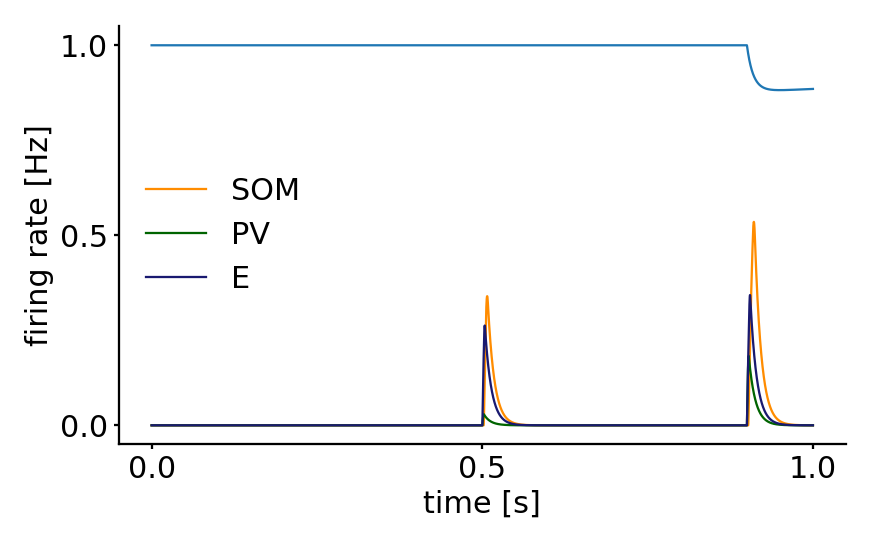

In [17]:
%matplotlib notebook
r1 = np.array([u1,p1,s1])
r2 = np.array([u2,p2,s2])
r3 = np.array([u3,p3,s3])


plot_rates(t,r1.T,savetitle='rates_positive_r1', figsize=(8,5))
plt.plot(t,g1)
save_fig(figure_directory, "all_activities_g_r1")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r1")


plot_rates(t,r2.T,savetitle='rates_positive_r1', figsize=(8,5))
plt.plot(t,g2)
save_fig(figure_directory, "all_activities_g_r2")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r3")


plot_rates(t,r3.T,savetitle='rates_positive_r1', figsize=(8,5))
plt.plot(t,g3)
save_fig(figure_directory, "all_activities_g_r3")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r3")

# Lateral connections

In [18]:
W_EE_lat = 1
W_ES_lat = 0
W_EP_lat = 0
W_PE_lat = 1.25
W_PP_lat = 0
W_PS_lat = 0
W_SE_lat = 0.125
W_SP_lat = 0
W_SS_lat = 0

W_lat = np.array([[W_EE_lat, W_ES_lat, W_EP_lat],
              [W_PE_lat, W_PP_lat, W_PS_lat],
              [W_SE_lat, W_SP_lat, W_SS_lat]])
print(W_lat)

for i in range(len(t)-1):
    # first column
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] + W_EE_lat*u2[i]+
                              + external_input1[0,i] + opto_input1[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] + W_PE_lat*u2[i]+
                              + external_input1[1,i] + opto_input1[1,i]- pth)
    sin1 = transfer_func_park(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i]  + W_SE_lat*u2[i]+
                              + external_input1[2,i] + opto_input1[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]
    
    
    # second column
    uin2 = transfer_func_park(W_EE*u2[i] + W_EP*p2[i] + W_ES*s2[i] + W_EE_lat*(u1[i]+u3[i])/2
                              + external_input2[0,i] + opto_input2[0,i] - uth)
    pin2 = transfer_func_park(W_PE*u2[i] + W_PP*p2[i] + W_PS*s2[i] + W_PE_lat*(u1[i]+u3[i])/2
                              + external_input2[1,i] + opto_input2[1,i]- pth)
    sin2 = transfer_func_park(W_SE*u2[i] + W_SP*p2[i] + W_SS*s2[i] + W_SE_lat*(u1[i]+u3[i])/2
                              + external_input2[2,i] + opto_input2[2,i]- sth)
    
    
    du2dt = -u2[i] + uin2
    dp2dt = -p2[i] + pin2
    ds2dt = -s2[i] + sin2

    u2[i+1] = u2[i] + du2dt*dt/taus[0] # integration step
    p2[i+1] = p2[i] + dp2dt*dt/taus[1]
    s2[i+1] = s2[i] + ds2dt*dt/taus[2]
    
    
    # third colum
    uin3 = transfer_func_park(W_EE*u3[i] + W_EP*p3[i] + W_ES*s3[i] + W_EE_lat*u2[i]
                              + external_input3[0,i] + opto_input3[0,i] - uth)
    pin3 = transfer_func_park(W_PE*u3[i] + W_PP*p3[i] + W_PS*s3[i] + W_PE_lat*u2[i]
                              + external_input3[1,i] + opto_input3[1,i]- pth)
    sin3 = transfer_func_park(W_SE*u3[i] + W_SP*p3[i] + W_SS*s3[i] + W_EE_lat*u2[i]
                              + external_input3[2,i] + opto_input3[2,i]- sth)
    
    
    du3dt = -u3[i] + uin3
    dp3dt = -p3[i] + pin3
    ds3dt = -s3[i] + sin3

    u3[i+1] = u3[i] + du3dt*dt/taus[0] # integration step
    p3[i+1] = p3[i] + dp3dt*dt/taus[1]
    s3[i+1] = s3[i] + ds3dt*dt/taus[2]
    
    

[[1.    0.    0.   ]
 [1.25  0.    0.   ]
 [0.125 0.    0.   ]]


<IPython.core.display.Javascript object>


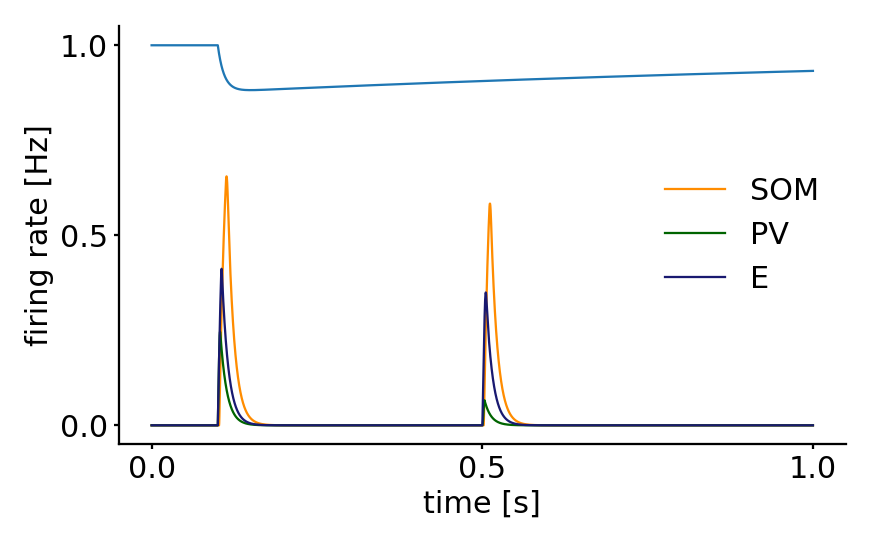

<IPython.core.display.Javascript object>


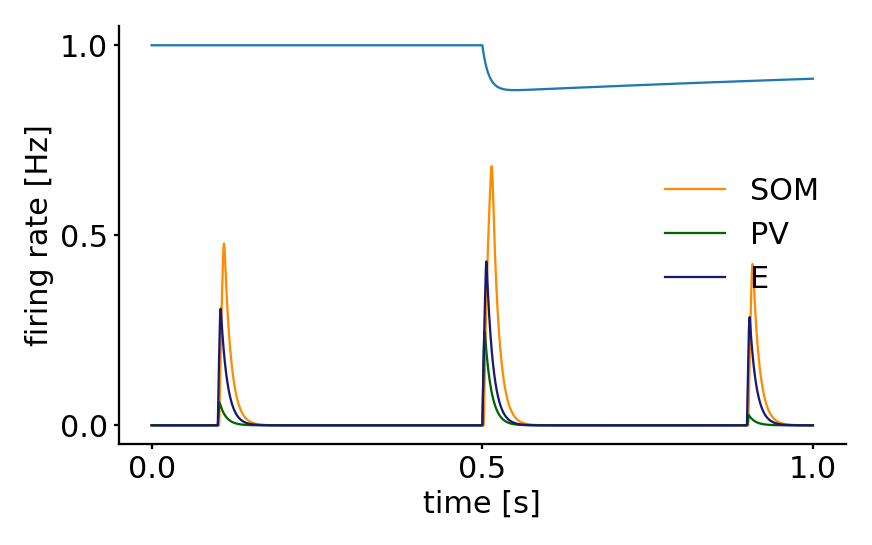

<IPython.core.display.Javascript object>


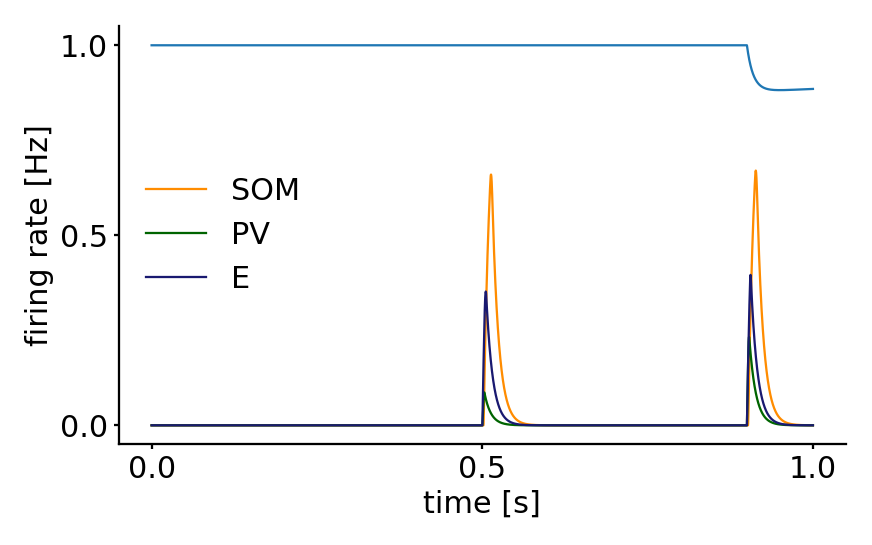

In [19]:
%matplotlib notebook
r1 = np.array([u1,p1,s1])
r2 = np.array([u2,p2,s2])
r3 = np.array([u3,p3,s3])


plot_rates(t,r1.T,savetitle='rates_positive_r1', figsize=(8,5))
plt.plot(t,g1)
save_fig(figure_directory, "all_activities_g_r1")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r1")


plot_rates(t,r2.T,savetitle='rates_positive_r1', figsize=(8,5))
plt.plot(t,g2)
save_fig(figure_directory, "all_activities_g_r2")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r3")


plot_rates(t,r3.T,savetitle='rates_positive_r1', figsize=(8,5))
plt.plot(t,g3)
save_fig(figure_directory, "all_activities_g_r3")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r3")

# 3 - Iso frequency model SSA
whole run   

In [281]:
color = ["midnightblue","darkgreen","darkorange","purple"]

# time in seconds
T, dt = 10, 0.0001 # s 
t = np.arange(0,T,dt)

# initialise weight matrices
# within microcircuit
W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1.1,-2,-1,1,-2,-2,6,0,0]
#W_EE, W_ES, W_EP,W_PE, W_PP, W_PS,W_SE, W_SP, W_SS = [1,0,0,0,0,0,0,0,0]

# lateral connections
W_EE_lat, W_ES_lat, W_EP_lat,W_PE_lat, W_PP_lat, W_PS_lat,W_SE_lat, W_SP_lat, W_SS_lat = [1,0,0,1.25,0,0,0.125,0,0]

# membrane time constants
taus = np.array([0.01, 0.01, 0.01]).T # all populations have a timeconstant of 10 ms
# population firing rate thresholds
uth = 0.7
pth = 1.
sth = 1.0



#stimulus parameters
# initialise the stimulus
# 1. set external stimulus input times
dur_stim = 0.1
dur_pause = 0.3
# first colum is the stimulus onset (evenly spaced over time T)
stim = stimulus(dur = dur_stim, pause=dur_pause, T=T)
#otherwise specify vector stim = [t1,t2,t3...]

q1 = 5 # input current step
q = 1.3 # 2nd q that multiplies the thalamic input distinct from q=5 for current 
alpha = 0.65 # reduction of lateral frequency stimulation
tau_input = 0.01 #s

#  2.call thalamic_input_current with respective stimulus times to receive low pass filtered version (like lp-filt spiketrain)
# thalamic_input_current(stimtimes, t, tau = tau_input, q = q1)

# input modulation g
g0 = 1
taud1 = 1.5 # s
taud2 = 0.100 # s

# 3. call thalamic_adaptation that modulates the input in an input specific way
# thalamic_adaptation(I, t, tau_d1 = taud1,tau_d2 = taud2, g0 = g0)

# ugly implementation of individual odes
u1 = np.zeros((len(t)))
p1 = np.zeros((len(t)))
s1 = np.zeros((len(t)))

u2 = np.zeros((len(t)))
p2 = np.zeros((len(t)))
s2 = np.zeros((len(t)))

u3 = np.zeros((len(t)))
p3 = np.zeros((len(t)))
s3 = np.zeros((len(t)))

opto_input1 = np.zeros((3,len(t)))
opto_input2 = np.zeros((3,len(t)))
opto_input3 = np.zeros((3,len(t)))

# first manually 
# st1 = [0.1, 1.3]
# st2 = [0.5, 1.7]
st2 = [2.4, 4.8, 7.2]
st1 = [0.4, 0.8, 1.2, 1.6, 2. , 2.8, 3.2, 3.6, 4. , 4.4, 5.2,
       5.6, 6. , 6.4, 6.8, 7.6, 8. , 8.4, 8.8, 9.2, 9.6]
st3 = [] # s
# ssa_stimulus(t,p_dev=0.1,dur_stim = 0.1,dur_pause=0.3, conditions = 10):
#st1,st2 = ssa_stimulus(t,p_dev,dur_stim=dur_stim,dur_pause=dur_pause)
I1 = thalamic_input_current(st1,t,q=q)
I2 = thalamic_input_current(st2,t,q=q)
I3 = thalamic_input_current(st3,t,q=q)

g1 = thalamic_adaptation(I1,t,g0=g0) # initialised with g = 1 and g0 = 1
g2 = thalamic_adaptation(I2,t,g0=g0) # initialised with g = 1 and g0 = 1
g3 = thalamic_adaptation(I3,t,g0=g0) # initialised with g = 1 and g0 = 1

in1 = I1 + alpha*I2
in2 = I2 + alpha*(I3+I1)
in3 = I3 + alpha*I2

external_input1 = q*np.tile(g1*in1,(3,1))
external_input2 = q*np.tile(g2*in2,(3,1))
external_input3 = q*np.tile(g3*in3,(3,1))

external_input1[2] = 0
external_input2[2] = 0
external_input3[2] = 0

24


In [282]:
# temporal integration
for i in range(len(t)-1):
    # first column
    uin1 = transfer_func_park(W_EE*u1[i] + W_EP*p1[i] + W_ES*s1[i] + W_EE_lat*u2[i]+
                              + external_input1[0,i] + opto_input1[0,i] - uth)
    pin1 = transfer_func_park(W_PE*u1[i] + W_PP*p1[i] + W_PS*s1[i] + W_PE_lat*u2[i]+
                              + external_input1[1,i] + opto_input1[1,i]- pth)
    sin1 = transfer_func_park(W_SE*u1[i] + W_SP*p1[i] + W_SS*s1[i]  + W_SE_lat*u2[i]+
                              + external_input1[2,i] + opto_input1[2,i]- sth)
    
    du1dt = -u1[i] + uin1
    dp1dt = -p1[i] + pin1
    ds1dt = -s1[i] + sin1

    u1[i+1] = u1[i] + du1dt*dt/taus[0] # integration step
    p1[i+1] = p1[i] + dp1dt*dt/taus[1]
    s1[i+1] = s1[i] + ds1dt*dt/taus[2]
    
    
    # second column
    uin2 = transfer_func_park(W_EE*u2[i] + W_EP*p2[i] + W_ES*s2[i] + W_EE_lat*(u1[i]+u3[i])/2
                              + external_input2[0,i] + opto_input2[0,i] - uth)
    pin2 = transfer_func_park(W_PE*u2[i] + W_PP*p2[i] + W_PS*s2[i] + W_PE_lat*(u1[i]+u3[i])/2
                              + external_input2[1,i] + opto_input2[1,i]- pth)
    sin2 = transfer_func_park(W_SE*u2[i] + W_SP*p2[i] + W_SS*s2[i] + W_SE_lat*(u1[i]+u3[i])/2
                              + external_input2[2,i] + opto_input2[2,i]- sth)
    
    
    du2dt = -u2[i] + uin2
    dp2dt = -p2[i] + pin2
    ds2dt = -s2[i] + sin2

    u2[i+1] = u2[i] + du2dt*dt/taus[0] # integration step
    p2[i+1] = p2[i] + dp2dt*dt/taus[1]
    s2[i+1] = s2[i] + ds2dt*dt/taus[2]
    
    
    # third colum
    uin3 = transfer_func_park(W_EE*u3[i] + W_EP*p3[i] + W_ES*s3[i] + W_EE_lat*u2[i]
                              + external_input3[0,i] + opto_input3[0,i] - uth)
    pin3 = transfer_func_park(W_PE*u3[i] + W_PP*p3[i] + W_PS*s3[i] + W_PE_lat*u2[i]
                              + external_input3[1,i] + opto_input3[1,i]- pth)
    sin3 = transfer_func_park(W_SE*u3[i] + W_SP*p3[i] + W_SS*s3[i] + W_EE_lat*u2[i]
                              + external_input3[2,i] + opto_input3[2,i]- sth)
    
    
    du3dt = -u3[i] + uin3
    dp3dt = -p3[i] + pin3
    ds3dt = -s3[i] + sin3

    u3[i+1] = u3[i] + du3dt*dt/taus[0] # integration step
    p3[i+1] = p3[i] + dp3dt*dt/taus[1]
    s3[i+1] = s3[i] + ds3dt*dt/taus[2]
    

<IPython.core.display.Javascript object>


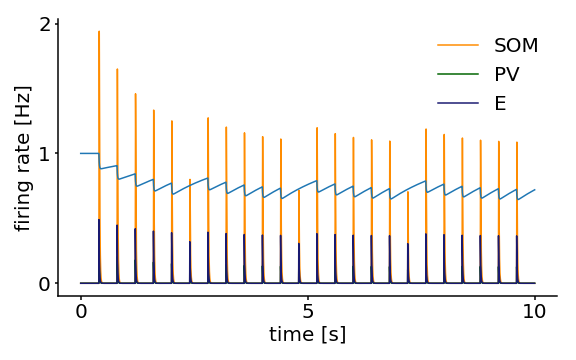

<IPython.core.display.Javascript object>


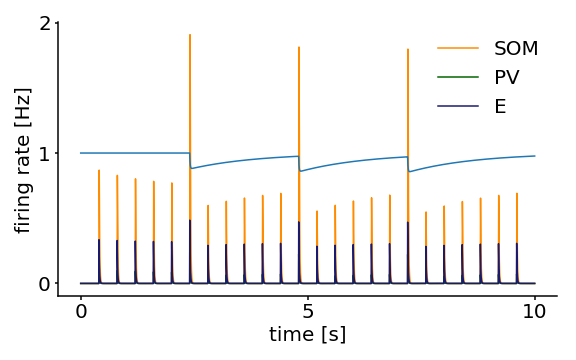

<IPython.core.display.Javascript object>


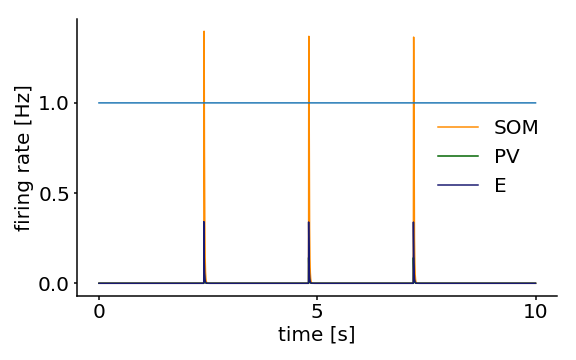

In [283]:
%matplotlib notebook
r1 = np.array([u1,p1,s1])
r2 = np.array([u2,p2,s2])
r3 = np.array([u3,p3,s3])


plot_rates(t,r1.T,savetitle='rates_positive_r1', figsize=(8,5))
plt.plot(t,g1)
save_fig(figure_directory, "all_activities_g_r1")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r1")


plot_rates(t,r2.T,savetitle='rates_positive_r1', figsize=(8,5))
plt.plot(t,g2)
save_fig(figure_directory, "all_activities_g_r2")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r3")


plot_rates(t,r3.T,savetitle='rates_positive_r1', figsize=(8,5))
plt.plot(t,g3)
save_fig(figure_directory, "all_activities_g_r3")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup_r3")

In [ ]:
plt.plot(t,g1)
plt.plot(t,g2)


In [218]:
# big difference if I stimulate middle frequency
# SSA it needs to be reversed
#90% 10 percent

# TO DO:
# get averages of all three excitatory units

# middle frequency recovers after deviant 
# side std frequency suppresses


<IPython.core.display.Javascript object>


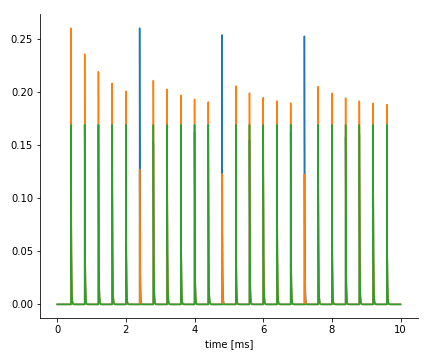

In [204]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)
plt.plot(t,external_input1[0,:]/(1.3*5), label='col 1')
plt.plot(t,external_input2[0,:]/(1.3*5), label='col 2')
plt.plot(t,external_input3[0,:]/(1.3*5), label='col 3')
# plt.plot(t,g1+15, color='grey', label='g 1')
# plt.plot(t,g2+9, color='grey', label='g 2')
# plt.plot(t,g3+3, color='grey',label='g 3')
#plt.yticks([])
#plt.legend()
plt.xlabel('time [ms]')
plt.tight_layout()

<IPython.core.display.Javascript object>


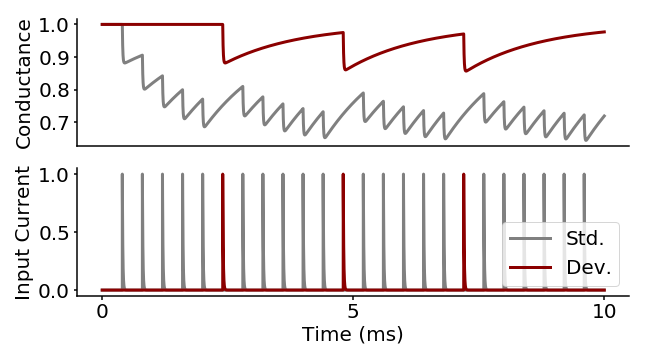

In [317]:
%matplotlib notebook
figsize=(9, 5)
ylabel = "Conductance"
xlabel =r"Time (ms)"
# subplot(nrows, ncols, index, **kwargs)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(211)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,g1, lw = 3, c = "grey", label="k = 10")
plt.plot(t,g2, lw = 3, c = "darkred", label="k = 10")

#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
#plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks([],fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
#plt.xlim([0,6])

plt.tight_layout()
ax = fig.add_subplot(212)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,I1/1.3, lw = 3, c = "grey", label="Std.")
plt.plot(t,I2/1.3, lw = 3, c = "darkred", label="Dev.")

#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")
ylabel = "Input Current"

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize, loc = 'lower right')
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
#plt.xlim([0,6])
plt.tight_layout()

save_fig(figure_directory, "g_input")

<IPython.core.display.Javascript object>


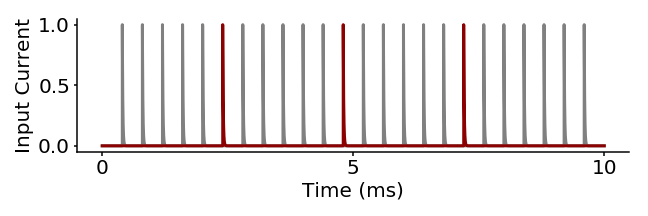

In [309]:
%matplotlib notebook
figsize=(9, 3)
ylabel = "Input Current"
xlabel =r"Time (ms)"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,I1/1.3, lw = 3, c = "grey", label="k = 10")
plt.plot(t,I2/1.3, lw = 3, c = "darkred", label="k = 10")

#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")
ylabel = "Input Current"

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
#plt.xlim([0,6])
plt.tight_layout()

save_fig(figure_directory, "input_input_current")



<IPython.core.display.Javascript object>


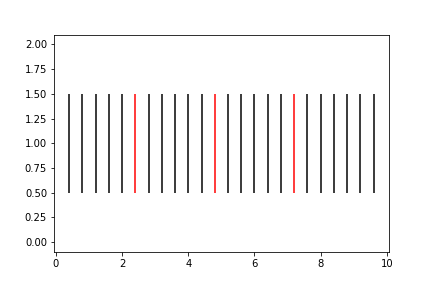

In [205]:
%matplotlib notebook
plt.eventplot(st1, color = 'red')
plt.eventplot(st2, color = 'black')

In [84]:
a = [1,2,3,4,5,6,7,8,9,10]
#b=np.random.shuffle(a)
b=sorted(a, key=lambda k: random.random())
print(b)

[4, 9, 8, 2, 10, 5, 3, 7, 1, 6]


In [68]:
stimtimes = stimulus(dur=dur_stim,pause=dur_pause,T=max(t))
p_dev=0.1
#sst1 = np.random.shuffle(stimtimes[:,0])
print(np.random.shuffle(stimtimes[:,0]))

np.random.shuffle(stimtimes[:,0])

23
None


TypeError: 'NoneType' object is not subscriptable

τuu
1 = −u1 + f(weeu1 − (wep(t) − aD1)p1 − (wes(t) + bF1)s1 + qI1(t) +w∗
eeu2),  
τpp
1 = −p1 + f(wpeu1 −wppp1 −wpss1 + IOpt,PV + qI1(t) +w∗
peu2),  
τss
1 = −s1 + f(wseu1 −wspp1 −wsss1 + IOpt,SOM +w∗
seu2),  

# Plotting

In [ ]:
%matplotlib notebook

#max_rate = maximum(r.flatten())[1]
#plot_rates(t,r.T/max_rate,savetitle='rates_positive')
plot_rates(t,r.T,savetitle='rates_positive')

plt.plot(t,g)
save_fig(figure_directory, "all_activities_g")
#plt.xlim([0.38,0.52])
# plt.plot(t,g*I, 'k')
save_fig(figure_directory, "all_activities_g_closeup")

In [ ]:
%matplotlib notebook
figsize=(9, 3)
ylabel = "g [mS]"
xlabel =r"time [ms]"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,g, lw = 3, c = "grey", label="k = 10")
#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "g_input")

In [ ]:
%matplotlib notebook
figsize=(9, 3)
ylabel = r"input current"
xlabel =r"time [ms]"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,I, lw = 3, c = "darkred", label="k = 10")
#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "input_current")

In [ ]:
%matplotlib notebook
figsize=(9, 3)
ylabel = r"thalamic input"
xlabel =r"time [ms]"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,thalamic_input, lw = 3, c = "darkred", label="k = 10")
#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "input_current")

In [ ]:
x = np.linspace(-1,2,100)
x_nl = np.copy(x)
for i in range(len(x)):
    x_nl[i] = transfer_func_park(x[i])

figsize=(5, 3)
ylabel = r"f(x)"
xlabel =r"x"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(x,x_nl, lw = 3, c = "darkblue", label="k = 10")
#plt.plot(x,y, lw = 3, c = "darkred", label="k = 1")

# for q in steps:
#     plt.axhline(y=q, c="grey")
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
# plt.legend(fontsize = fontsize)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "nonlinearity_xy")

In [ ]:
%matplotlib notebook
figsize=(9, 3)
ylabel = "g [mS]"
xlabel =r"time [ms]"

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
axiswidth = 1.5
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(axiswidth)
ax.xaxis.set_tick_params(width=axiswidth)
ax.yaxis.set_tick_params(width=axiswidth)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
plt.plot(t,g, label='g ')
plt.plot(t,I, label='I ')
plt.plot(t,q*g*I, label='1.3*g*I')
#plt.legend()
plt.xlabel(xlabel, fontsize = fontsize)
plt.ylabel(ylabel, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize, frameon = False,loc = 'upper left')
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()

save_fig(figure_directory, "inputs_g_i_gi")

### Adaptation network

In [ ]:
# adaptation variables
T_adapt = np.array([[1.5, 1.5],[0.02, 0.02]])
g0 = np.ones(2)*10

thalamic_drive = np.array([1,1,0]).T
thalamic_onset = 0.1
opto_onset = 5

y0 = np.hstack((np.zeros(3),g0))

r = integrate.odeint(network_TC_adapt, y0, t, args=(W, tau_neurons, T_adapt, g0))
plt.figure(figsize=(8,6))
plot_rates(t,r[:,:3]+r0, W)
plt.figure(figsize=(8,3))
plt.plot(t,r[:,3:])
plt.title('Adaptation Variables')

In [ ]:
def thalamic_adaptation(I, t, tau_d1 = 1.5,tau_d2 = 0.02, g0 = 1.):
    # return thalamic adaptation of one synapse g
    # I input current 
    # t total time
    # taud1 replenishment of NT at synapse 1.5s
    # depletion of vesicles 
    g = np.ones(len(t))
    dt = t[1]-t[0]
    for i in range(len(t)-1):
        dgdt = (g0-g[i])/tau_d1 - g[i]*I[i]/tau_d2
        print(dgdt)
        g[i+1] = g[i] + dgdt*dt
    return g

In [ ]:
gg = thalamic_adaptation(I, t)

# Non linearity

In [ ]:
def f(x, al = 3):
    return al*np.heaviside(x,1)*x*np.heaviside(1/al-x,1)+np.heaviside(x-1/al,1)
# dan(x)=exp(-tl*x)
# p al = 3


x = np.linspace(-5,5,100)
ff = f(x)

%matplotlib notebook
plt.plot(x,ff)